### Используемые библиотеки

In [947]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

### Настройки ноутбука

In [2]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [514]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

### Загрузка данных

In [4]:
# Загрузка данных
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
new_data = pd.read_csv('/Users/kost/Desktop/решено/data/ssp_stat_load_car-94-96.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')
edf = pd.read_csv('RZD.csv', sep='\t', encoding='utf-8')

In [5]:
# Датасет отсортированный по станции > номеру вагона > времени операции
# ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

# Датасет из свежих данных от 21/05/21
ndf = new_data.copy().sort_values(by=['operation_date'])

### Справочные функции

In [7]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        v = f'По вагону: {car_ops[car_ops.index_code == operation_code].values[0]}'
    except:
        v = 'NOP'
    try:
        p = f'По поезду: {train_ops[train_ops.index_code == operation_code].values[0]}'
    except:
        p = 'NOP'
    
    return [v,p]
    
get_op_info(3)

["По вагону: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']",
 "По поезду: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']"]

In [10]:
def extract_train(index_train):
    lst = []
    for i,j in enumerate(str(index_train)):
        lst.append(j)
        i+=1
    print('Единая Сетевая Разметка, ЕСР:', ''.join(lst[0:6]))
    print('Порядковый номер состава:', ''.join(lst[6:9]))
    print('ЕСР железнодорожной станции назначения поезда:', ''.join(lst[9:16]))

In [206]:
def extract_car(car_number):
    lst = []
    for i,j in enumerate(str(car_number)):
        if i == 0 and j == '2':
            lst.append('крытый')
        elif i == 0 and j == '3':
            lst.append('специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)')
        elif i == 0 and j == '4':
            lst.append('платформы')
        elif i == 0 and j == '5':
            lst.append('означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»')
        elif i == 0 and j == '6':
            lst.append('полувагон')
        elif i == 0 and j == '7':
            lst.append('цистерны')
        elif i == 0 and j == '8':
            lst.append('изотермические')
        elif i == 0 and j == '9':
            lst.append('прочие')
        elif i == 1 and j == '2':
            lst.append('двух осный')
        elif i == 1 and j == '4':
            lst.append('четырех осный')
        elif i == 1 and j == '6':
            lst.append('шести осный')
        elif i == 1 and j == '8':
            lst.append('восьми осный')
        elif i == 1 and j == '12':
            lst.append('двенадцати осный')
        elif i == 1 and j == '16':
            lst.append('шестнадцати осный')
        elif i == 2 and j == '5':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '6':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '7':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '8':
            lst.append('цистерна с объемом котла 75 м3')
        elif i == 2 and j == '9':
            lst.append('цистерна с объемом котла 85,6 м3')
        elif i == 3 and j.isdigit():
            lst.append('номер вагона который был присвоен заводом: {}'.format(j))
        elif i == 4 and j.isdigit():
            lst.append(j)
        elif i == 5 and j.isdigit():
            lst.append(j)
        elif i == 6 and j.isdigit():
            lst.append('имеется ручной тормоз или переходная площадка, код: {}'.format(j))
        elif i == 7 and j.isdigit():
            lst.append('контрольное число вагона: {}'.format(j))
        else:
            continue
            
    print(f'Вагон {car_num} был отмечен на следующих станциях:\n')
    for i in ndf.operation_st_esr[ndf.car_number == car_num].unique(): print(i)

    print(f'\nВагон {car_num} был отмечен в следующих поездах:\n')
    for i in ndf.index_train[ndf.car_number == car_num].unique(): 
        if np.isnan(i): 
            continue
        else:
            print(int(i))
    print(f'\nСвойства:\n{lst}')

In [169]:
extract_train(954704366955406)

Единая Сетевая Разметка, ЕСР: 954704
Порядковый номер состава: 366
ЕСР железнодорожной станции назначения поезда: 955406


In [188]:
extract_car(67062638)

Вагон 67062638 был отмечен на следующих станциях:

950101
956305
952906

Вагон 67062638 был отмечен в следющих поездах:

970001524950101
950101857956305
956305498950101
950101861956305
961407474950101
950101863956305
956305504950101
950101301951706
950101309951706

Свойства:
['полувагон', 'номер вагона который был присвоен заводом: 6', '2', '6', 'имеется ручной тормоз или переходная площадка, код: 3', 'контрольное число вагона: 8']


### Анализ датасета

<AxesSubplot:>

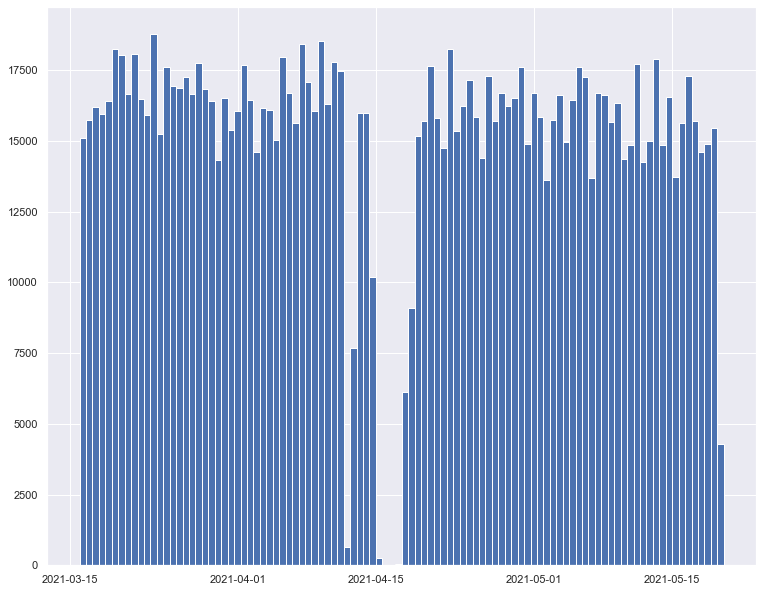

In [161]:
ndf.operation_date.hist(bins=100)

In [200]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

print(f'Количество вагонов которые были отправлены хотя бы один раз:\
 {ndf.car_number[ndf.operation_car == 2].nunique()}')
print(f'В датасете нет данных об отправке\
 {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов')

Размерность датасета: (1501134, 44)

Временной диапазон:
min: 2021-03-16 00:01:00
max: 2021-05-20 05:51:00

Уникальных станций: 141
Уникальных вагонов: 119768

Количество вагонов которые были отправлены хотя бы один раз: 95585
В датасете нет данных об отправке 24183 уникальных вагонов


In [201]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
3 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
81 ['УБОРКА ВАГОНА С ПП                    ']
80 [' ПОДАЧА ВАГОНА НА ПП                  ']
2 ['ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
21 ['ВЫГРУЗКА НА ПП                        ']
8 ['ПРИБЫТИЕ ВАГОНА НА СТАНЦИЮ            ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
79 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
78 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
30 ['ЗАНЯТИЕ ПРИ СОРТ. МЕЛКИХ ОТП. И КОНТ. ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
40 ['ОСВОБ. ПРИ СОРТ.МЕЛК.ОТПРАВОК И КОНТ. ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']


In [202]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
1.0 ['Приб. поезда на станцию (без приема на дорогу, отделение, участок ДНЦ)']
72.0 ['Отцепка вагонов']
71.0 ['Прицепка вагонов']
51.0 ['Приб. поезда на станцию с приемом на участок ДНЦ']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
44.0 ['Подача маршрута под грузовые операции']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
11.0 ['Приб. поезда с приемом на дорогу, из-за границы или новостройки']
35.0 ['Образование соединенного поезда']


### Визуализация датасета

In [374]:
## В этой ячейке задаются переменные st_id - ЕСР станции, car_num - номер вагона.
## Задавая значения переменным можно проводить визуальный анализ по определенной станции или вагону.

"""
Примеры номеров станций ['operation_st_esr']
"""
# st_id = 889505 # 100 ops, 4 cars
# st_id = 845009 # 90 ops, 28 cars
# st_id = 977000 # 50 ops, 10 cars
# st_id = 985906 # 207037 ops, 43702 cars
# st_id = 925701 # 37386 ops, 3801 cars
# st_id = 926206 # 18489 ops, 363 cars
# st_id = 880407
# st_id = 967704 # станция с аномальными данными - таможенный пост Морской порт Ванино 
# st_id = 881804
# st_id = 986103 # top-1 by dest # НАХОДКА-ВОСТОЧНАЯ (ЭКСП.) https://www.logistics1520.com/railway/station/98610-nahodka-vostochnaya-eksp/
# st_id = 863007 # 5th by destination
# st_id = 950101
# st_id = 954704
st_id = 968707 # Дземги - https://www.logistics1520.com/railway/station/96870-dzemgi/


"""
Примеры номеров вагонов ['car_number']
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712
# car_num = 30870752
# car_num = 42051359
# car_num = 42780155
# car_num = 30061394
# car_num = 55952550
# car_num = 67062638 ## вагон с наглядым графом перехода состояний
# car_num = 53447488
car_num = 54643101

"""
Примеры номеров поездов ['index_train']
"""
train_num = 954704366955406

#######################

# проверка соответствия st_id и car_num
def check_st_car(st_id, car_num):
    if ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().index[:10],
                 'Строк': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
            pd.DataFrame(
                {'Станция': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().index,
                 'Строк': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().values}
            )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )


check_st_car(st_id, car_num)
print(f'\nВагон {car_num} также присутствует в записях со следующими поездами: \n\n\
{ndf.index_train[ndf.car_number == car_num].value_counts()}')

Для станции 968707 есть 50 строк(а) по вагону 54643101

Вагон 54643101 также присутствует в записях со следующими поездами: 

960007553968707.00    3
968707424960007.00    3
968707331960103.00    2
968707262960007.00    2
960007509968707.00    2
960007363968707.00    2
968707287960103.00    2
968707393960007.00    2
968707543960103.00    2
960007436970001.00    2
960007538968707.00    1
960007464968707.00    1
985906018968707.00    1
Name: index_train, dtype: int64


In [355]:
print(f'Для визуализации используются следующие переменные:\n\nst_id \t= {st_id}\ncar_num = {car_num}\n')
print(f'В датасете по станции {st_id} имеются записи по:\n\n{ndf.car_number[ndf.operation_st_esr == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_esr == st_id].shape[0]} операциям\n')
extract_car(car_num)

Для визуализации используются следующие переменные:

st_id 	= 968707
car_num = 54643101

В датасете по станции 968707 имеются записи по:

10670 вагонам и
141749 операциям

Вагон 54643101 был отмечен на следующих станциях:

968707
960007

Вагон 54643101 был отмечен в следующих поездах:

960007363968707
968707262960007
985906018968707
968707287960103
960007436970001
960007464968707
968707331960103
960007509968707
968707393960007
960007538968707
968707424960007
960007553968707
968707543960103

Свойства:
['означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»', 'четырех осный', 'четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М', 'номер вагона который был присвоен заводом: 4', '3', '1', 'имеется ручной тормоз или переходная площадка, код: 0', 'контрольное число вагона: 1']


#### Анализ количества операций на станции по вагонам

Displaing first 800 operations out of 141749:


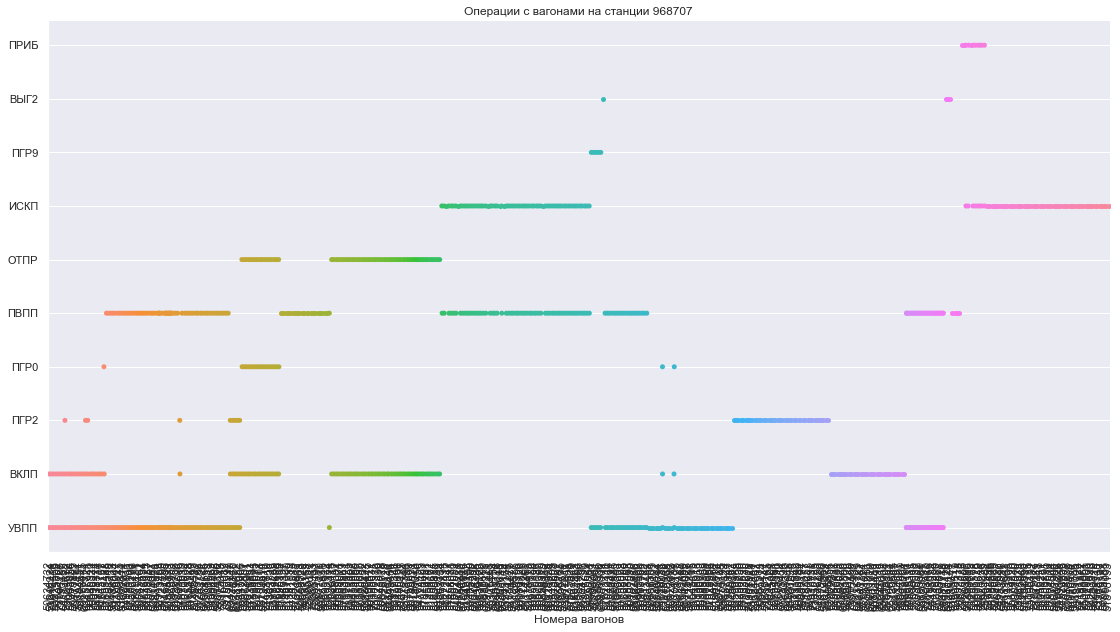

In [356]:
tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
tmp_df = tmp_df[['car_number','operation_car']]
tmp_df.car_number = tmp_df.car_number.apply(lambda x: str(x))
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

if tmp_df.shape[0] > 800:
    print(f"Displaing first 800 operations out of {tmp_df.shape[0]}:")
    tmp_df = tmp_df.loc[:800]


sns.catplot(x=tmp_df['car_number'], y=tmp_df['operation_car'],data=tmp_df,height=8, aspect=4/2)
plt.ylabel('')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
# plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()
# del(tmp_df)

#### Анализ количества операций на станции по времени операции

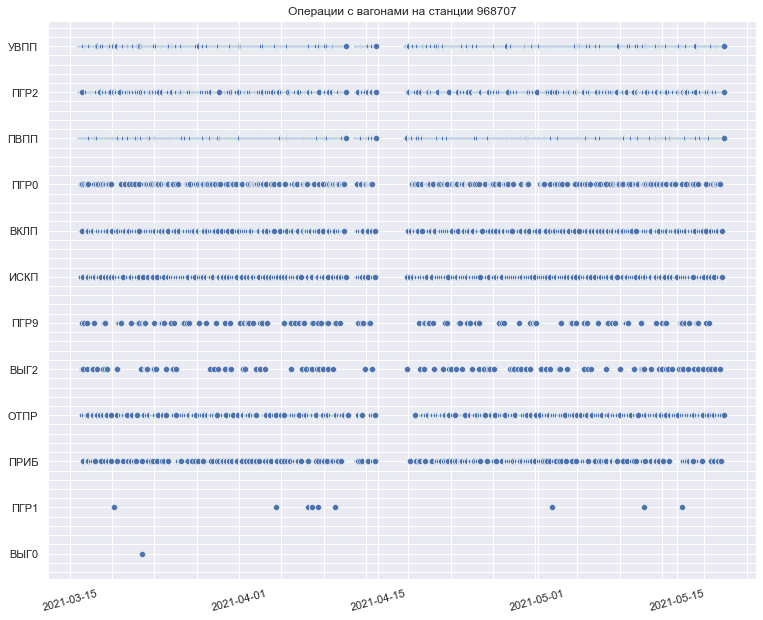

In [357]:
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Анализ операций с вагоном на станции по времени

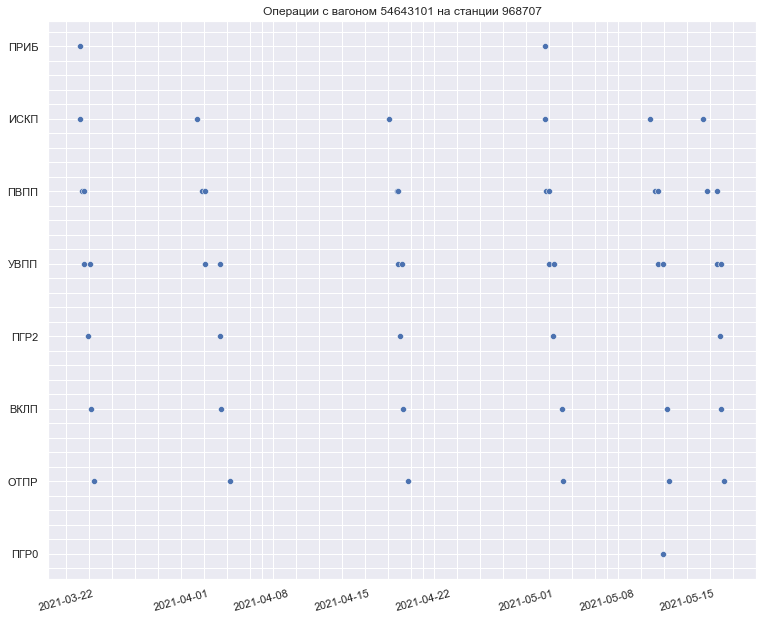

In [358]:
warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_esr == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Граф последовательностей операций и количества переходов

In [228]:
def count_ops_transitions(car: int) -> dict:
    """
    Функция строит словарь с уникальными перехеодами по операциям с вагоном и количеством таких переходов.
    :param car: Номер вагона
    :return: Словарь с уникальными переходами по операциям и их количеством. 
    Пример словаря: {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
        
    opsListCart = list(ndf[ndf.car_number == car].sort_values(by=['operation_date'])['operation_car'])
    sChangeDF = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
    
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

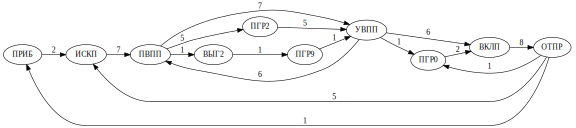

In [359]:
sdict = count_ops_transitions(car_num)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

# DG.view() # экспорт в pdf
DG

#### Граф последовательностей операций с вагоном с указанием времени между операциями

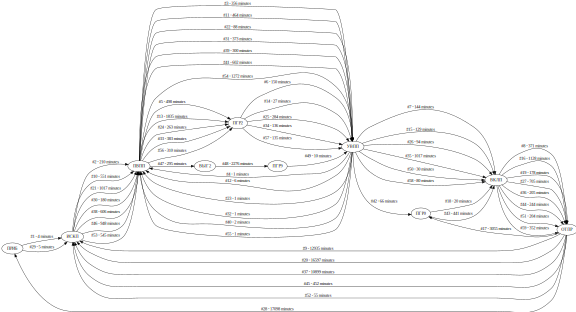

In [360]:
# построить граф переходов между операциями по вагону
# timedelta64[m] - в минутах
# timedelta64[h] - в часах

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # экспорт в pdf
DG # отобразить граф в ячейке

### Анализ цепочек операций

In [242]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_esr == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_esr == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [361]:
# выборка последовательностей операций по вагонам на станции заданной в st_id
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 10670/10670 [02:15<00:00, 78.60it/s]


{70723119: '81 81 80 11 81',
 73001315: '81 80 81 80 81 80 11 81  4  4  2',
 51020733: '81 80 81 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 50915263: '81 80 81 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 51454395: '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 81 80 11 81  4  2',
 50933399: '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 11 81  4  2',
 73032161: '81 80 81 80 81 80 11 81  4  2',
 50938208: '81 80 81 80 81  4  2  3 80 81 80 81 18  4  2',
 51999753: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 50965953: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 54884978: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 56727795: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 54723465: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 75033712: '81 80 81 80 11 81  4 81  4',
 54080718: '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 

In [362]:
# аггрегация цепочек операций по вагонам по станции заданной в st_id
agg_by_car(cars_ops)

{'81 81 80 11 81': [70723119],
 '81 80 81 80 81 80 11 81  4  4  2': [73001315],
 '81 80 81 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [51020733, 50915263],
 '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 81 80 11 81  4  2': [51454395],
 '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 11 81  4  2': [50933399],
 '81 80 81 80 81 80 11 81  4  2': [73032161],
 '81 80 81 80 81  4  2  3 80 81 80 81 18  4  2': [50938208],
 '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [51999753,
  50965953,
  54884978,
  56727795,
  54723465],
 '81 80 81 80 11 81  4 81  4': [75033712],
 '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 80 81 80 11 81  4  2  8  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [54080718],
 '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 80 81 80 11 81  4  2  8  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [75039867,
  57191066,
  73003410,
  57595381],
 '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 80 81 80

In [363]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'3 80 81 80 11 81  4  2': 961,
 '3 80 11 81  4  2': 724,
 '8  3 80 81 80 11 81  4  2': 319,
 '8  3 80 11 81  4  2': 266,
 '3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': 224,
 '3 80': 166,
 '3 80 11 81  4  2  3 80 11 81  4  2': 146,
 '3': 117,
 '11 81  4  2': 91,
 '8  3 80 11 81  4  2  3 80 11 81  4  2': 84,
 '3 80 81 80 11 81': 78,
 '3 80 81 80 11 81  4  3 80 81 80 11 81  4  2': 76,
 '8  3 80 81 80 11 81': 71,
 '3 80 81 80 11 81  4  2  8  3 80 81 80 11 81  4  2': 71,
 '3 80 11 81  4  2  8  3 80 11 81  4  2': 71,
 '3 80 81 80 81 18  4  2': 65,
 '8  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': 64,
 '8  3 80': 62,
 '3 80 11 81  4  2  3 80 11 81  4  2  3 80 11 81  4  2': 61,
 '3 80 11 81': 54,
 '3 80 11  4  2': 50,
 '3 80 81  4  2': 47,
 '80 81 80 11 81  4  2': 44,
 '3 81 80 11 81  4  2': 44,
 '3 80 81 80 19 81  4  2': 42,
 '3 80 80 11 81  4  2': 40,
 '80 11 81  4  2': 39,
 '3 80 11 81  4  2  3 80 11 81  4  2  8  3 80 11 81  4  2': 39,
 '8  3 80 81 80 11 81  4  2  8  3 80 81 80 11 

In [246]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)

ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 950101:
[18.0, 4.0, 2.0]


In [247]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']


### Формирование датасета для обучения моделей

In [248]:
tst = ndf[ndf.operation_date < '2021-03-16 23:59:59']
tst = tst[tst.operation_date > '2021-03-15 23:59:59']

In [250]:
'''
Выборка операций погрузки/разгрузки
21 ['ВЫГРУЗКА НА ПП                        ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
'''
ops = [21, 19, 11, 18, 20, 10, 28, 29]

#### Промежуточный датасет с историей операций относительно operation_car

In [253]:
def build_df_for_train(df,ops):

    ## выбрать индексы нужных операций
    ops_index = pd.core.indexes.numeric.Int64Index([],dtype='int64')
    for op in ops:        
        ops_index = ops_index.append(df[df.operation_car == op].index)
    
    ## по индексам формируем словари с фичами
    ops_dict,times_dict,future_dict = dict.fromkeys(ops_index),dict.fromkeys(ops_index),dict.fromkeys(ops_index)
    for index in tqdm(ops_index):

        car_num = df.car_number[df.index == index].values[0]
        time_op = df.operation_date[df.index == index].values[0]

        temp_df = df[df.car_number == car_num].copy()
        
        temp_df = temp_df.sort_values(by=['operation_date'])
        
        temp_df_future = temp_df[temp_df.operation_date > time_op]
        
        
        try:
            f1 = temp_df_future.operation_car.values[0]
            f2 = temp_df_future.operation_date.values[0] - time_op
            
        except:
            f1 = np.nan
            f2 = np.datetime64('')

        future = [f1,f2.astype('timedelta64[m]')]
        
        temp_df_past = temp_df[temp_df.operation_date <= time_op]
        temp_df_past = temp_df_past.drop(index,axis='index')

        times_list = time_op - temp_df_past.operation_date[-4:].iloc[::-1].values
        ops_list = temp_df_past.operation_car[-4:].iloc[::-1].values

        # to flip indexes .iloc[::-1]

        future_dict[index] = future
        times_dict[index] = times_list
        ops_dict[index] = ops_list
    
    ## конвертируем словари в pandas df
    df1 = pd.DataFrame.from_dict(times_dict,orient='index',columns=['minus1_timedelta','minus2_timedelta','minus3_timedelta','minus4_timedelta'])
    df2 = pd.DataFrame.from_dict(ops_dict,orient='index',columns=['minus1_op','minus2_op','minus3_op','minus4_op'])
    df3 = pd.DataFrame.from_dict(future_dict,orient='index',columns=['future_op','future_op_timedelta'])
    
    return pd.concat([df3,df.loc[ops_index],df2, df1], axis=1)

In [254]:
## посторить датасет zzz из датасета tst по списку операций ops (см выше)
zzz = build_df_for_train(tst,ops)
zzz

100%|██████████| 5164/5164 [00:16<00:00, 310.94it/s]


,future_op,future_op_timedelta,adm,car_number,danger,destination_esr,destination_id,group_car,gruz,id,index_train,innovag,int_disl,kds,kod_group,length,loaded,lves,number_train,ont_time_write,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,operator,park,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,stkgos_id,tare_weight,track,train_id,uns,weight,weight_brutto,weight_netto,following_mark,processing_road,junction,special_mark_1,dispatch_id,minus1_op,minus2_op,minus3_op,minus4_op,minus1_timedelta,minus2_timedelta,minus3_timedelta,minus4_timedelta
13934,NaN,NaT,26,75003517,1.00,954102.00,2000038256.00,0.00,212052.00,2320791766432,NaN,NaN,1,242,0.00,0.86,2,NaN,NaN,2021-03-17 09:06:05.92,21,2021-03-16 00:05:00,954102,2000038256,NaN,0,NaN,18278026.00,70,NaN,98770511.00,NaN,NaN,NaN,255,NaN,NaN,796944892,62560.00,NaN,NaN,0,94,NaN,0.00,2083ЭЦ059595,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
3896,81.00,0 days 02:45:00,27,54085923,1.00,967600.00,2000038600.00,0.00,221066.00,2320791626518,NaN,NaN,1,242,4.00,0.86,2,NaN,NaN,2021-03-17 09:05:28.911,21,2021-03-16 00:07:00,967600,2000038600,NaN,0,NaN,74568897.00,70,NaN,0.00,NaN,NaN,NaN,266,NaN,NaN,796944929,65993.00,NaN,NaN,0,96,NaN,3.00,2092ЭЦ172212,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
3861,81.00,0 days 02:45:00,20,53992103,1.00,967600.00,2000038600.00,0.00,221066.00,2320791624884,NaN,NaN,1,242,4.00,0.86,2,NaN,NaN,2021-03-17 09:05:28.911,21,2021-03-16 00:07:00,967600,2000038600,NaN,58718274,NaN,74568897.00,70,NaN,0.00,NaN,NaN,NaN,267,NaN,NaN,796944929,65613.00,NaN,NaN,0,96,NaN,3.00,2092ЭЦ172212,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
1710,81.00,0 days 02:45:00,20,50215490,1.00,967600.00,2000038600.00,0.00,221066.00,2320791584319,NaN,NaN,1,242,4.00,0.86,2,NaN,NaN,2021-03-17 09:05:17.908,21,2021-03-16 00:07:00,967600,2000038600,NaN,95149153,NaN,74568897.00,70,NaN,0.00,NaN,NaN,NaN,267,NaN,NaN,796944929,65776.00,NaN,NaN,0,96,NaN,3.00,2092ЭЦ172212,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
4096,81.00,0 days 02:45:00,20,54756671,1.00,967600.00,2000038600.00,0.00,221066.00,2320791634211,NaN,NaN,1,242,0.00,0.86,2,NaN,NaN,2021-03-17 09:05:30.912,21,2021-03-16 00:07:00,967600,2000038600,NaN,15199450,NaN,74568897.00,70,NaN,48134187.00,NaN,NaN,NaN,258,NaN,NaN,796944929,59620.00,NaN,NaN,0,96,NaN,0.00,2088ЭЦ047311,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14280,81.00,0 days 00:27:00,20,94507753,NaN,960103.00,2000038372.00,0.00,3009.00,2320791776400,NaN,NaN,1,421,0.00,1.41,1,NaN,NaN,2021-03-17 09:06:08.92,10,2021-03-16 17:03:00,954704,2000038282,NaN,91712232,NaN,0.00,96,NaN,0.00,NaN,NaN,NaN,218,NaN,NaN,798018301,67610.00,NaN,NaN,0,94,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
6499,4.00,0 days 02:24:00,20,60366457,NaN,924501.00,2000036806.00,0.00,151060.00,2320791678988,NaN,NaN,0,410,4.00,1.00,1,NaN,NaN,2021-03-17 09:05:43.914,10,2021-03-16 17:06:00,967808,2000038604,NaN,14267669,NaN,5785247.00,60,NaN,1126163.00,NaN,NaN,NaN,242,NaN,NaN,798020201,69000.00,NaN,NaN,0,96,NaN,3.00,2096ЭЦ859114,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
6189,4.00,0 days 02:24:00,20,60387222,NaN,924501.00,2000036806.00,0.00,151060.00,2320791679236,NaN,NaN,0,410,4.00,1.00,1,NaN,NaN,2021-03-17 09:05:43.914,10,2021-03-16 17:06:00,967808,2000038604,NaN,14267669,NaN,5785247.00,60,NaN,1126163.00,NaN,NaN,NaN,243,NaN,NaN,798020201,68300.00,NaN,NaN,0,96,NaN,3.00,2096ЭЦ859114,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
7789,4.00,0 days 02:24:00,20,61526976,NaN,924501.00,2000036806.00,0.00,151060.00,2320791692119,NaN,NaN,0,410,4.00,1.00,1,NaN,NaN,2021-03-17 09:05:46.915,10,2021-03-16 17:06:00,967808,2000038604,NaN,58693261,NaN,5785247.00,60,NaN,1126163.00,NaN,NaN,NaN,243,NaN,NaN,798020201,67700.00,NaN,NaN,0,96,NaN,3.00,2096ЭЦ859114,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT


#### Выборка индексов операций ОТПР удовлетворяющих условиям:  "погрузка/разгрузка" -> "включение в поезд" -> "отправление"

In [258]:
## Проверяется факт погрузки/разгрузки, затем ищем операцию отправления и если предыдущия операция 
## операция включения в поезд, запоминаем индекс операции отправления

def get_list_of_indexes_with_success(df, cars):
    x = []

    for car in tqdm(cars):
#         print(f'\n\t{car}')

        ops_with_car_df = df[df.car_number == car].sort_values(by=['operation_date'])['operation_car']

        for cycle, i in enumerate(ops_with_car_df.index):
#             print(df.loc[i]['operation_car'])  ## for debug
            if df.loc[i]['operation_car'] in ops:
                load_unload = df.loc[i]['operation_st_esr']
            if df.loc[i]['operation_car'] == 2:
                if df.loc[ops_with_car_df.index[cycle - 1]]['operation_car'] == 4:
                    if load_unload == df.loc[i]['operation_st_esr']:
#                         print(df.loc[i]['index_train'])
#                         print(df.loc[i]['operation_date'])   
#                         print(df.loc[ops_with_car_df.index[cycle - 1]]['operation_date'])
#                         print('reset load state')
                        x.append(i)
                        load_unload = False
                else:
#                     print('reset load state')
                    load_unload = False
        
    return x

In [259]:
x = get_list_of_indexes_with_success(ndf, ndf.car_number.unique())

100%|██████████| 119768/119768 [15:43<00:00, 126.91it/s]


In [266]:
# экспорт списка индексов для загрузки на GitHub
with open('selected_ops.txt', 'w') as f:
    for item in x:
        f.write("%s\n" % item)

In [267]:
# новый столбец с таргетом
dff = ndf.assign(target=pd.Series(dtype=int))
# помечаем все найденные индексы 
dff['target'].loc[x] = 1

<AxesSubplot:>

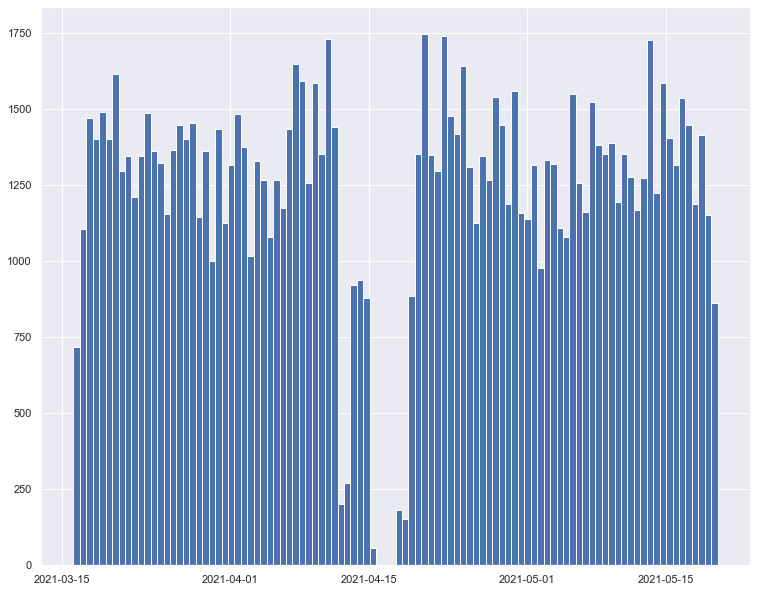

In [294]:
dff.operation_date[dff.target == 1].hist(bins=100)

<AxesSubplot:>

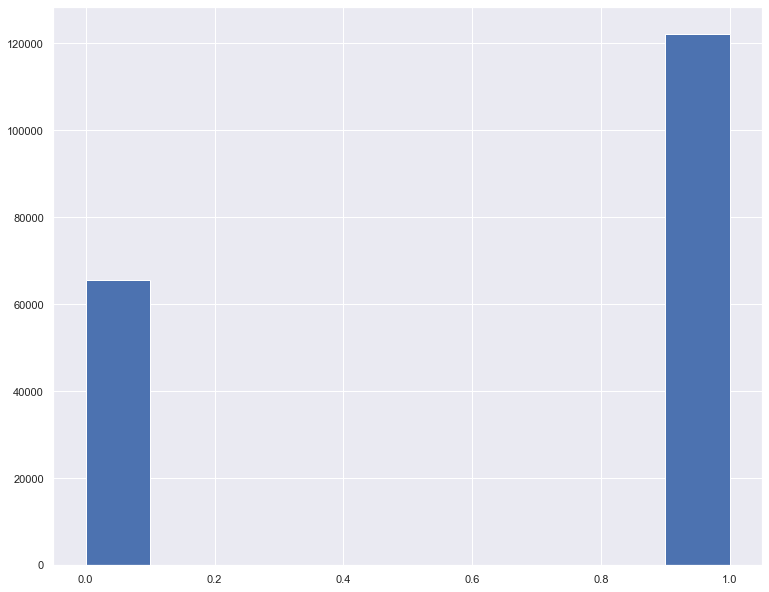

In [293]:
dff.target.fillna(0)[dff.operation_car == 2].hist()

In [271]:
dff[['operation_st_esr','destination_esr','index_train']][dff.target == 1]

,operation_st_esr,destination_esr,index_train
15360,944007,944609.00,944007360944609.00
15356,944007,944609.00,944007360944609.00
15371,944007,944609.00,944007360944609.00
15370,944007,944609.00,944007360944609.00
15361,944007,944609.00,944007360944609.00
...,...,...,...
1490184,967600,918801.00,967600870960007.00
1490187,967600,917207.00,967600870960007.00
1490138,967600,960103.00,967600870960007.00
1490137,967600,863806.00,967600870960007.00


#### Таблица с количеством интересующих операций отправления по парам станций из индекса поезда

In [272]:
def count_cars(df):
    pairs = {}
    counts = df.index_train[df.target == 1].value_counts()
    for count in counts.index: 
        src = str(int(count // 1e9))
        dst = str(int(count % 1e6))
        entry = src +'->'+dst 
        if entry in pairs:
            pairs[entry] += counts[count]
        else:
            pairs[entry] = counts[count]
    return pairs

In [690]:
tm_from = dff.operation_date.min()
full_tdf = pd.DataFrame()
while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    full_tdf = pd.concat([full_tdf,tdf], axis=1)

#### Таблица по станции назначения поезда

In [691]:
def count_cars_dst(df):
    pairs = {}
    counts = df.index_train[df.target == 1].value_counts()
    for count in counts.index: 
        dst = str(int(count % 1e6)) 
        if dst in pairs:
            pairs[dst] += counts[count]
        else:
            pairs[dst] = counts[count]
    return pairs

tm_from = dff.operation_date.min()
full_tdf_dst = pd.DataFrame()
while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars_dst(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    full_tdf_dst = pd.concat([full_tdf_dst,tdf], axis=1)

#### Таблица по станции операции

In [793]:
def count_cars_op(df):
    op_st_esr = {}
    counts = df.operation_st_esr[df.target == 1].value_counts()
    for count in counts.index: 
        st_esr = str(int(count)) 
        if st_esr in op_st_esr:
            op_st_esr[st_esr] += counts[count]
        else:
            op_st_esr[st_esr] = counts[count]
    return op_st_esr

tm_from = dff.operation_date.min()

full_tdf_op = pd.DataFrame()

while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars_op(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    full_tdf_op  = pd.concat([full_tdf_op,tdf], axis=1)

In [794]:
full_tdf.fillna(0,inplace=True)
full_tdf_dst.fillna(0,inplace=True)
full_tdf_op.fillna(0,inplace=True)

In [695]:
# датасет по направлению
full_tdf.head()

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,2021-03-17 00:01:00,2021-03-17 04:01:00,2021-03-17 08:01:00,2021-03-17 12:01:00,2021-03-17 16:01:00,2021-03-17 20:01:00,2021-03-18 00:01:00,2021-03-18 04:01:00,2021-03-18 08:01:00,2021-03-18 12:01:00,2021-03-18 16:01:00,2021-03-18 20:01:00,2021-03-19 00:01:00,2021-03-19 04:01:00,2021-03-19 08:01:00,2021-03-19 12:01:00,2021-03-19 16:01:00,2021-03-19 20:01:00,2021-03-20 00:01:00,2021-03-20 04:01:00,2021-03-20 08:01:00,2021-03-20 12:01:00,2021-03-20 16:01:00,2021-03-20 20:01:00,2021-03-21 00:01:00,2021-03-21 04:01:00,2021-03-21 08:01:00,2021-03-21 12:01:00,2021-03-21 16:01:00,2021-03-21 20:01:00,2021-03-22 00:01:00,2021-03-22 04:01:00,2021-03-22 08:01:00,2021-03-22 12:01:00,2021-03-22 16:01:00,2021-03-22 20:01:00,2021-03-23 00:01:00,2021-03-23 04:01:00,2021-03-23 08:01:00,2021-03-23 12:01:00,2021-03-23 16:01:00,2021-03-23 20:01:00,2021-03-24 00:01:00,2021-03-24 04:01:00,2021-03-24 08:01:00,2021-03-24 12:01:00,2021-03-24 16:01:00,2021-03-24 20:01:00,2021-03-25 00:01:00,2021-03-25 04:01:00,2021-03-25 08:01:00,2021-03-25 12:01:00,2021-03-25 16:01:00,2021-03-25 20:01:00,2021-03-26 00:01:00,2021-03-26 04:01:00,2021-03-26 08:01:00,2021-03-26 12:01:00,2021-03-26 16:01:00,2021-03-26 20:01:00,2021-03-27 00:01:00,2021-03-27 04:01:00,2021-03-27 08:01:00,2021-03-27 12:01:00,2021-03-27 16:01:00,2021-03-27 20:01:00,2021-03-28 00:01:00,2021-03-28 04:01:00,2021-03-28 08:01:00,2021-03-28 12:01:00,2021-03-28 16:01:00,2021-03-28 20:01:00,2021-03-29 00:01:00,2021-03-29 04:01:00,2021-03-29 08:01:00,2021-03-29 12:01:00,2021-03-29 16:01:00,2021-03-29 20:01:00,2021-03-30 00:01:00,2021-03-30 04:01:00,2021-03-30 08:01:00,2021-03-30 12:01:00,2021-03-30 16:01:00,2021-03-30 20:01:00,2021-03-31 00:01:00,2021-03-31 04:01:00,2021-03-31 08:01:00,2021-03-31 12:01:00,2021-03-31 16:01:00,2021-03-31 20:01:00,2021-04-01 00:01:00,2021-04-01 04:01:00,2021-04-01 08:01:00,2021-04-01 12:01:00,2021-04-01 16:01:00,2021-04-01 20:01:00,2021-04-02 00:01:00,2021-04-02 04:01:00,2021-04-02 08:01:00,2021-04-02 12:01:00,2021-04-02 16:01:00,2021-04-02 20:01:00,2021-04-03 00:01:00,2021-04-03 04:01:00,2021-04-03 08:01:00,2021-04-03 12:01:00,2021-04-03 16:01:00,2021-04-03 20:01:00,2021-04-04 00:01:00,2021-04-04 04:01:00,2021-04-04 08:01:00,2021-04-04 12:01:00,2021-04-04 16:01:00,2021-04-04 20:01:00,2021-04-05 00:01:00,2021-04-05 04:01:00,2021-04-05 08:01:00,2021-04-05 12:01:00,2021-04-05 16:01:00,2021-04-05 20:01:00,2021-04-06 00:01:00,2021-04-06 04:01:00,2021-04-06 08:01:00,2021-04-06 12:01:00,2021-04-06 16:01:00,2021-04-06 20:01:00,2021-04-07 00:01:00,2021-04-07 04:01:00,2021-04-07 08:01:00,2021-04-07 12:01:00,2021-04-07 16:01:00,2021-04-07 20:01:00,2021-04-08 00:01:00,2021-04-08 04:01:00,2021-04-08 08:01:00,2021-04-08 12:01:00,2021-04-08 16:01:00,2021-04-08 20:01:00,2021-04-09 00:01:00,2021-04-09 04:01:00,2021-04-09 08:01:00,2021-04-09 12:01:00,2021-04-09 16:01:00,2021-04-09 20:01:00,2021-04-10 00:01:00,2021-04-10 04:01:00,2021-04-10 08:01:00,2021-04-10 12:01:00,2021-04-10 16:01:00,2021-04-10 20:01:00,2021-04-11 00:01:00,2021-04-11 04:01:00,2021-04-11 08:01:00,2021-04-11 12:01:00,2021-04-11 16:01:00,2021-04-11 20:01:00,2021-04-12 00:01:00,2021-04-12 04:01:00,2021-04-12 08:01:00,2021-04-12 12:01:00,2021-04-12 16:01:00,2021-04-12 20:01:00,2021-04-13 00:01:00,2021-04-13 04:01:00,2021-04-13 08:01:00,2021-04-13 12:01:00,2021-04-13 16:01:00,2021-04-13 20:01:00,2021-04-14 00:01:00,2021-04-14 04:01:00,2021-04-14 08:01:00,2021-04-14 12:01:00,2021-04-14 16:01:00,2021-04-14 20:01:00,2021-04-15 00:01:00,2021-04-15 04:01:00,2021-04-15 08:01:00,2021-04-15 12:01:00,2021-04-15 16:01:00,2021-04-15 20:01:00,2021-04-16 00:01:00,2021-04-16 04:01:00,2021-04-16 08:01:00,2021-04-16 12:01:00,2021-04-16 16:01:00,2021-04-16 20:01:00,2021-04-17 00:01:00,2021-04-17 04:01:00,2021-04-17 08:01:00,2021-04-17 12:01:00,2021-04-17 16:01:00,2021-04-17 20:01:00,2021-04-18 00:01:00,2021-04-18 04:01:00,2021-04-18 08:01:00

In [696]:
# датасет по станции назначения
full_tdf_dst.head()

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,2021-03-17 00:01:00,2021-03-17 04:01:00,2021-03-17 08:01:00,2021-03-17 12:01:00,2021-03-17 16:01:00,2021-03-17 20:01:00,2021-03-18 00:01:00,2021-03-18 04:01:00,2021-03-18 08:01:00,2021-03-18 12:01:00,2021-03-18 16:01:00,2021-03-18 20:01:00,2021-03-19 00:01:00,2021-03-19 04:01:00,2021-03-19 08:01:00,2021-03-19 12:01:00,2021-03-19 16:01:00,2021-03-19 20:01:00,2021-03-20 00:01:00,2021-03-20 04:01:00,2021-03-20 08:01:00,2021-03-20 12:01:00,2021-03-20 16:01:00,2021-03-20 20:01:00,2021-03-21 00:01:00,2021-03-21 04:01:00,2021-03-21 08:01:00,2021-03-21 12:01:00,2021-03-21 16:01:00,2021-03-21 20:01:00,2021-03-22 00:01:00,2021-03-22 04:01:00,2021-03-22 08:01:00,2021-03-22 12:01:00,2021-03-22 16:01:00,2021-03-22 20:01:00,2021-03-23 00:01:00,2021-03-23 04:01:00,2021-03-23 08:01:00,2021-03-23 12:01:00,2021-03-23 16:01:00,2021-03-23 20:01:00,2021-03-24 00:01:00,2021-03-24 04:01:00,2021-03-24 08:01:00,2021-03-24 12:01:00,2021-03-24 16:01:00,2021-03-24 20:01:00,2021-03-25 00:01:00,2021-03-25 04:01:00,2021-03-25 08:01:00,2021-03-25 12:01:00,2021-03-25 16:01:00,2021-03-25 20:01:00,2021-03-26 00:01:00,2021-03-26 04:01:00,2021-03-26 08:01:00,2021-03-26 12:01:00,2021-03-26 16:01:00,2021-03-26 20:01:00,2021-03-27 00:01:00,2021-03-27 04:01:00,2021-03-27 08:01:00,2021-03-27 12:01:00,2021-03-27 16:01:00,2021-03-27 20:01:00,2021-03-28 00:01:00,2021-03-28 04:01:00,2021-03-28 08:01:00,2021-03-28 12:01:00,2021-03-28 16:01:00,2021-03-28 20:01:00,2021-03-29 00:01:00,2021-03-29 04:01:00,2021-03-29 08:01:00,2021-03-29 12:01:00,2021-03-29 16:01:00,2021-03-29 20:01:00,2021-03-30 00:01:00,2021-03-30 04:01:00,2021-03-30 08:01:00,2021-03-30 12:01:00,2021-03-30 16:01:00,2021-03-30 20:01:00,2021-03-31 00:01:00,2021-03-31 04:01:00,2021-03-31 08:01:00,2021-03-31 12:01:00,2021-03-31 16:01:00,2021-03-31 20:01:00,2021-04-01 00:01:00,2021-04-01 04:01:00,2021-04-01 08:01:00,2021-04-01 12:01:00,2021-04-01 16:01:00,2021-04-01 20:01:00,2021-04-02 00:01:00,2021-04-02 04:01:00,2021-04-02 08:01:00,2021-04-02 12:01:00,2021-04-02 16:01:00,2021-04-02 20:01:00,2021-04-03 00:01:00,2021-04-03 04:01:00,2021-04-03 08:01:00,2021-04-03 12:01:00,2021-04-03 16:01:00,2021-04-03 20:01:00,2021-04-04 00:01:00,2021-04-04 04:01:00,2021-04-04 08:01:00,2021-04-04 12:01:00,2021-04-04 16:01:00,2021-04-04 20:01:00,2021-04-05 00:01:00,2021-04-05 04:01:00,2021-04-05 08:01:00,2021-04-05 12:01:00,2021-04-05 16:01:00,2021-04-05 20:01:00,2021-04-06 00:01:00,2021-04-06 04:01:00,2021-04-06 08:01:00,2021-04-06 12:01:00,2021-04-06 16:01:00,2021-04-06 20:01:00,2021-04-07 00:01:00,2021-04-07 04:01:00,2021-04-07 08:01:00,2021-04-07 12:01:00,2021-04-07 16:01:00,2021-04-07 20:01:00,2021-04-08 00:01:00,2021-04-08 04:01:00,2021-04-08 08:01:00,2021-04-08 12:01:00,2021-04-08 16:01:00,2021-04-08 20:01:00,2021-04-09 00:01:00,2021-04-09 04:01:00,2021-04-09 08:01:00,2021-04-09 12:01:00,2021-04-09 16:01:00,2021-04-09 20:01:00,2021-04-10 00:01:00,2021-04-10 04:01:00,2021-04-10 08:01:00,2021-04-10 12:01:00,2021-04-10 16:01:00,2021-04-10 20:01:00,2021-04-11 00:01:00,2021-04-11 04:01:00,2021-04-11 08:01:00,2021-04-11 12:01:00,2021-04-11 16:01:00,2021-04-11 20:01:00,2021-04-12 00:01:00,2021-04-12 04:01:00,2021-04-12 08:01:00,2021-04-12 12:01:00,2021-04-12 16:01:00,2021-04-12 20:01:00,2021-04-13 00:01:00,2021-04-13 04:01:00,2021-04-13 08:01:00,2021-04-13 12:01:00,2021-04-13 16:01:00,2021-04-13 20:01:00,2021-04-14 00:01:00,2021-04-14 04:01:00,2021-04-14 08:01:00,2021-04-14 12:01:00,2021-04-14 16:01:00,2021-04-14 20:01:00,2021-04-15 00:01:00,2021-04-15 04:01:00,2021-04-15 08:01:00,2021-04-15 12:01:00,2021-04-15 16:01:00,2021-04-15 20:01:00,2021-04-16 00:01:00,2021-04-16 04:01:00,2021-04-16 08:01:00,2021-04-16 12:01:00,2021-04-16 16:01:00,2021-04-16 20:01:00,2021-04-17 00:01:00,2021-04-17 04:01:00,2021-04-17 08:01:00,2021-04-17 12:01:00,2021-04-17 16:01:00,2021-04-17 20:01:00,2021-04-18 00:01:00,2021-04-18 04:01:00,2021-04-18 08:01:00

In [697]:
# датасет по станции операции
full_tdf_op.head()

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,2021-03-17 00:01:00,2021-03-17 04:01:00,2021-03-17 08:01:00,2021-03-17 12:01:00,2021-03-17 16:01:00,2021-03-17 20:01:00,2021-03-18 00:01:00,2021-03-18 04:01:00,2021-03-18 08:01:00,2021-03-18 12:01:00,2021-03-18 16:01:00,2021-03-18 20:01:00,2021-03-19 00:01:00,2021-03-19 04:01:00,2021-03-19 08:01:00,2021-03-19 12:01:00,2021-03-19 16:01:00,2021-03-19 20:01:00,2021-03-20 00:01:00,2021-03-20 04:01:00,2021-03-20 08:01:00,2021-03-20 12:01:00,2021-03-20 16:01:00,2021-03-20 20:01:00,2021-03-21 00:01:00,2021-03-21 04:01:00,2021-03-21 08:01:00,2021-03-21 12:01:00,2021-03-21 16:01:00,2021-03-21 20:01:00,2021-03-22 00:01:00,2021-03-22 04:01:00,2021-03-22 08:01:00,2021-03-22 12:01:00,2021-03-22 16:01:00,2021-03-22 20:01:00,2021-03-23 00:01:00,2021-03-23 04:01:00,2021-03-23 08:01:00,2021-03-23 12:01:00,2021-03-23 16:01:00,2021-03-23 20:01:00,2021-03-24 00:01:00,2021-03-24 04:01:00,2021-03-24 08:01:00,2021-03-24 12:01:00,2021-03-24 16:01:00,2021-03-24 20:01:00,2021-03-25 00:01:00,2021-03-25 04:01:00,2021-03-25 08:01:00,2021-03-25 12:01:00,2021-03-25 16:01:00,2021-03-25 20:01:00,2021-03-26 00:01:00,2021-03-26 04:01:00,2021-03-26 08:01:00,2021-03-26 12:01:00,2021-03-26 16:01:00,2021-03-26 20:01:00,2021-03-27 00:01:00,2021-03-27 04:01:00,2021-03-27 08:01:00,2021-03-27 12:01:00,2021-03-27 16:01:00,2021-03-27 20:01:00,2021-03-28 00:01:00,2021-03-28 04:01:00,2021-03-28 08:01:00,2021-03-28 12:01:00,2021-03-28 16:01:00,2021-03-28 20:01:00,2021-03-29 00:01:00,2021-03-29 04:01:00,2021-03-29 08:01:00,2021-03-29 12:01:00,2021-03-29 16:01:00,2021-03-29 20:01:00,2021-03-30 00:01:00,2021-03-30 04:01:00,2021-03-30 08:01:00,2021-03-30 12:01:00,2021-03-30 16:01:00,2021-03-30 20:01:00,2021-03-31 00:01:00,2021-03-31 04:01:00,2021-03-31 08:01:00,2021-03-31 12:01:00,2021-03-31 16:01:00,2021-03-31 20:01:00,2021-04-01 00:01:00,2021-04-01 04:01:00,2021-04-01 08:01:00,2021-04-01 12:01:00,2021-04-01 16:01:00,2021-04-01 20:01:00,2021-04-02 00:01:00,2021-04-02 04:01:00,2021-04-02 08:01:00,2021-04-02 12:01:00,2021-04-02 16:01:00,2021-04-02 20:01:00,2021-04-03 00:01:00,2021-04-03 04:01:00,2021-04-03 08:01:00,2021-04-03 12:01:00,2021-04-03 16:01:00,2021-04-03 20:01:00,2021-04-04 00:01:00,2021-04-04 04:01:00,2021-04-04 08:01:00,2021-04-04 12:01:00,2021-04-04 16:01:00,2021-04-04 20:01:00,2021-04-05 00:01:00,2021-04-05 04:01:00,2021-04-05 08:01:00,2021-04-05 12:01:00,2021-04-05 16:01:00,2021-04-05 20:01:00,2021-04-06 00:01:00,2021-04-06 04:01:00,2021-04-06 08:01:00,2021-04-06 12:01:00,2021-04-06 16:01:00,2021-04-06 20:01:00,2021-04-07 00:01:00,2021-04-07 04:01:00,2021-04-07 08:01:00,2021-04-07 12:01:00,2021-04-07 16:01:00,2021-04-07 20:01:00,2021-04-08 00:01:00,2021-04-08 04:01:00,2021-04-08 08:01:00,2021-04-08 12:01:00,2021-04-08 16:01:00,2021-04-08 20:01:00,2021-04-09 00:01:00,2021-04-09 04:01:00,2021-04-09 08:01:00,2021-04-09 12:01:00,2021-04-09 16:01:00,2021-04-09 20:01:00,2021-04-10 00:01:00,2021-04-10 04:01:00,2021-04-10 08:01:00,2021-04-10 12:01:00,2021-04-10 16:01:00,2021-04-10 20:01:00,2021-04-11 00:01:00,2021-04-11 04:01:00,2021-04-11 08:01:00,2021-04-11 12:01:00,2021-04-11 16:01:00,2021-04-11 20:01:00,2021-04-12 00:01:00,2021-04-12 04:01:00,2021-04-12 08:01:00,2021-04-12 12:01:00,2021-04-12 16:01:00,2021-04-12 20:01:00,2021-04-13 00:01:00,2021-04-13 04:01:00,2021-04-13 08:01:00,2021-04-13 12:01:00,2021-04-13 16:01:00,2021-04-13 20:01:00,2021-04-14 00:01:00,2021-04-14 04:01:00,2021-04-14 08:01:00,2021-04-14 12:01:00,2021-04-14 16:01:00,2021-04-14 20:01:00,2021-04-15 00:01:00,2021-04-15 04:01:00,2021-04-15 08:01:00,2021-04-15 12:01:00,2021-04-15 16:01:00,2021-04-15 20:01:00,2021-04-16 00:01:00,2021-04-16 04:01:00,2021-04-16 08:01:00,2021-04-16 12:01:00,2021-04-16 16:01:00,2021-04-16 20:01:00,2021-04-17 00:01:00,2021-04-17 04:01:00,2021-04-17 08:01:00,2021-04-17 12:01:00,2021-04-17 16:01:00,2021-04-17 20:01:00,2021-04-18 00:01:00,2021-04-18 04:01:00,2021-04-18 08:01:00

### Предсказания с помощью XGBoost 

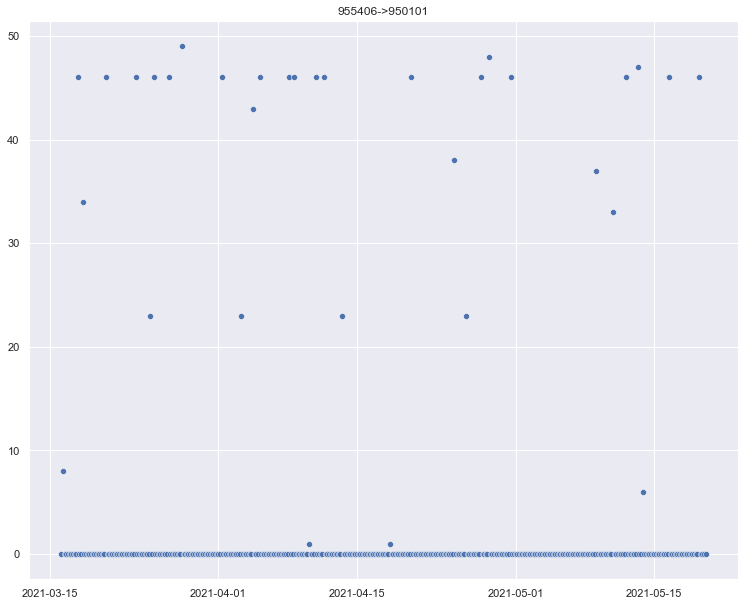

In [698]:
k = 3 # 
sns.scatterplot(y=full_tdf.iloc[k].values,x=full_tdf.iloc[k].keys(),data=full_tdf.iloc[k])
plt.title(full_tdf.index[k])
plt.show()

In [699]:
full_tdf.iloc[k]

2021-03-16 04:01:00    0.00
2021-03-16 08:01:00    8.00
2021-03-16 12:01:00    0.00
2021-03-16 16:01:00    0.00
2021-03-16 20:01:00    0.00
                       ... 
2021-05-19 12:01:00   46.00
2021-05-19 16:01:00    0.00
2021-05-19 20:01:00    0.00
2021-05-20 00:01:00    0.00
2021-05-20 04:01:00    0.00
Name: 955406->950101, Length: 391, dtype: float64

In [285]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [286]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [287]:
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = max(0, np.round(model.predict(np.expand_dims(testX, axis=(0)))[0],0))
    return yhat

In [288]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in tqdm(range(len(test))):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
#         print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [823]:
def predict_and_plot(series,df,title):
    values = series.values
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=4)

    # evaluate
    mae, y, yhat = walk_forward_validation(data, 50)
    print('MAE: %.3f' % mae)
    # plot expected vs preducted
    plt.plot(y, label='Expected')
    plt.plot(yhat, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

100%|██████████| 50/50 [00:08<00:00,  6.21it/s]


MAE: 5.980


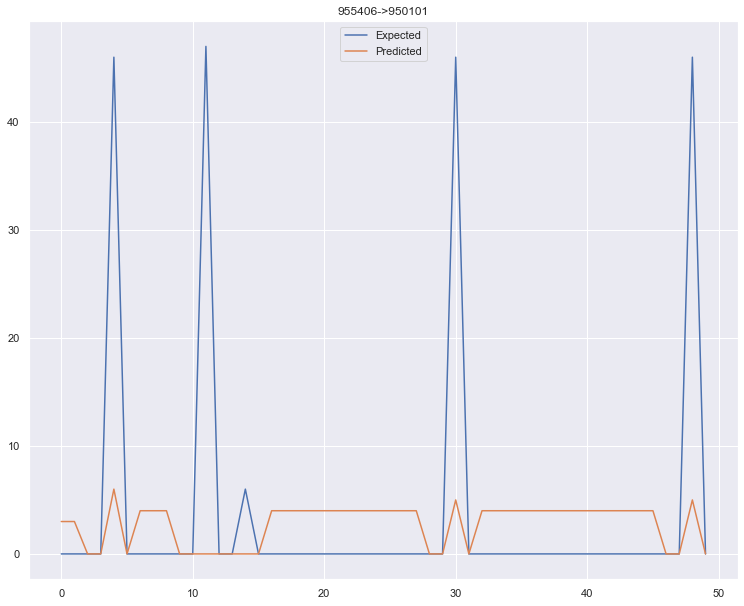

In [824]:
series = full_tdf.iloc[k]
predict_and_plot(series,full_tdf,full_tdf.index[k])

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


MAE: 9.760


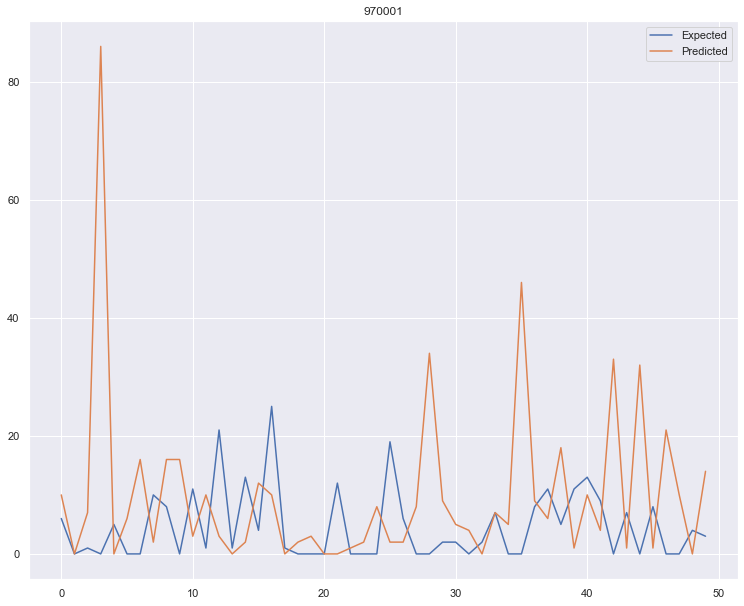

In [825]:
series = full_tdf_dst.iloc[k]
predict_and_plot(series,full_tdf_dst,full_tdf_dst.index[k])

100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


MAE: 40.220


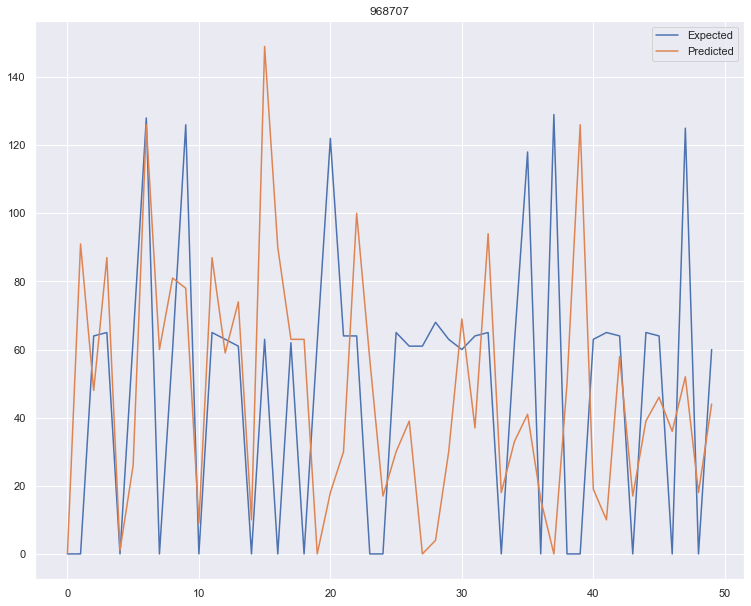

In [826]:
series = full_tdf_op[full_tdf_op.index == '968707'].loc['968707']
predict_and_plot(series,full_tdf_op,st_id)

#### Очистка исходного датасета, проверка гипотез

In [301]:
# выбираем только данные после провала 16-18 апреля
clean_df = ndf[ndf.operation_date > pd.Timestamp('2021-04-19 00:00:00')]
print(f'Размерность исходного датасета\t{ndf.shape}')
print(f'Размерность нового датасета\t{clean_df.shape}')

Размерность исходного датасета	(1501134, 44)
Размерность нового датасета	(749957, 44)


In [312]:
# выборка станций на которых была хотя бы одна операция отправления
print(f'Размерность датасета до очистки\t{clean_df.shape}')
clean_df = clean_df[clean_df.operation_st_esr.isin(clean_df.operation_st_esr[clean_df.operation_car == 2].unique())]
print(f'Размерность датасета после очистки\t{clean_df.shape}')

Размерность датасета до очистки	(749957, 44)
Размерность датасета после очистки	(714803, 44)


In [327]:
# выборка операций отправления
cx = get_list_of_indexes_with_success(clean_df, clean_df.car_number.unique())
# новый столбец с таргетом
clean_df = clean_df.assign(target=pd.Series(dtype=int))
# помечаем все найденные индексы 
clean_df['target'].loc[cx] = 1

100%|██████████| 74037/74037 [07:35<00:00, 162.47it/s]


In [703]:
# формирование таблицы с количеством вагонов
tm_from = clean_df.operation_date.min()
clean_tdf = pd.DataFrame()
while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = clean_df[clean_df.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    clean_tdf = pd.concat([clean_tdf,tdf], axis=1)

In [704]:
clean_tdf.fillna(0,inplace=True)

100%|██████████| 50/50 [00:07<00:00,  6.27it/s]


MAE: 0.620


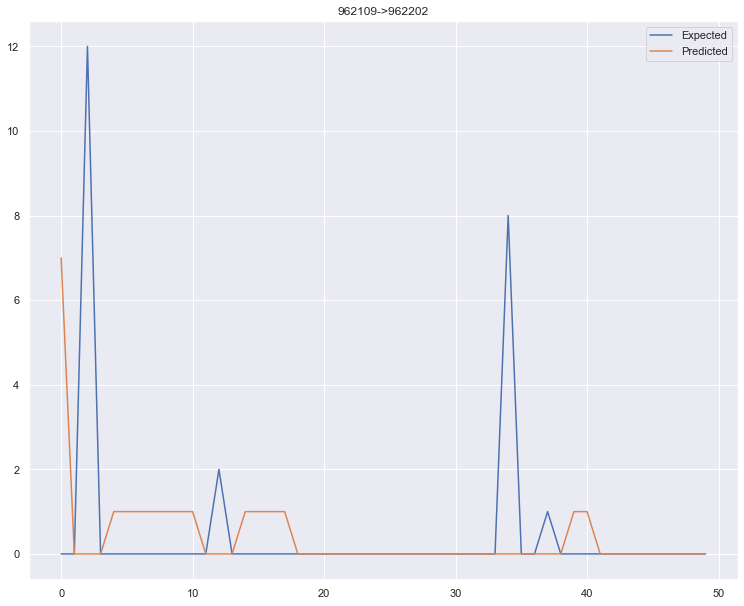

In [705]:
series = clean_tdf.iloc[k]
predict_and_plot(series,clean_tdf)

#### Граф по наиболее нагруженным направлениям

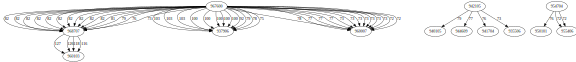

In [352]:
DG = Digraph(f'Top 100 trains by number of cars', filename='top_trains')
DG.attr(rankdir='TB', size='8,5')

c = clean_df.index_train[clean_df.target == 1].value_counts()

for i in range(50):
    src = str(c.index[i])[:6]
    dst = str(c.index[i])[9:-2]
    DG.edge(src, dst,label=f'{c.values[i]}')

DG

### Формирование датасета по исходным параметрам по станции

In [688]:
def build_series(df,st_id):

    ops = [21, 19, 11, 18, 20, 10, 28, 29]
    df = df[df.operation_st_esr == st_id]
    df_dict = {}

    df_dict['dang_cars_sent'] = df[df.danger == 1][df.operation_car == 2].shape[0]
    df_dict['inno_cars_sent'] = df.car_number[df.innovag == 1][df.operation_car == 2].nunique()
    df_dict['load_cars_sent'] = df[df.loaded == 1][df.operation_car == 2].shape[0]
    df_dict['empt_cars_sent'] = df[df.loaded == 2][df.operation_car == 2].shape[0]    
    for i in range(1,6):
        df_dict[f'grp{i}_cars_sent'] = df.car_number[df.kod_group == i][df.operation_car == 2].nunique()
    for i in range(1,10):
        df_dict[f'sp_mark_{i}_sent'] = df[df.special_mark_1 == i][df.operation_car == 2].shape[0]
        
    df_dict['sum_len_cars_sent'] = np.round(df.length[df.operation_car == 2].sum(),2)
    df_dict['sum_wgt_cars_sent'] = df.weight[df.operation_car == 2].sum() / 1000 # tonns
    
    # 40 - платформы, 41 - платформа 2х ярусная для перевозки автомобилей
    df_dict['platf_sent'] = df.car_number[df.rodvag.isin([40,41])][df.operation_car == 2].nunique()
    # 60 - полувагоны, 61 - полувагоны глуходонные
    df_dict['gcar_sent'] = df.car_number[df.rodvag.isin([60,61])][df.operation_car == 2].nunique()
    # 70 - цистерны
    df_dict['tanks_sent'] = df.car_number[df.rodvag.isin(np.arange(70,79))][df.operation_car == 2].nunique()
    # 20 - крытые
    df_dict['covrd_sent'] = df.car_number[df.rodvag.isin([20])][df.operation_car == 2].nunique()
    # 90 - прочие
    df_dict['oth_sent'] = df.car_number[df.rodvag.isin(np.arange(90,99))][df.operation_car == 2].nunique()
    # 80 - вагоны термоса, 81 - рефрижираторные
    df_dict['therm_sent'] = df.car_number[df.rodvag.isin(np.arange(80,81))][df.operation_car == 2].nunique()    


    df_dict['cars_num'] = df.car_number.nunique()
    df_dict['dest_esr_num'] = df.destination_esr.nunique()
    df_dict['gruz_codes_num'] = df.gruz.nunique()    
    
    df_dict['operators_num'] = df.operator.nunique()
    df_dict['senders_num'] = df.receiver.nunique()
    df_dict['recievers_num'] = df.sender.nunique()
    
    df_dict['train_types_num'] = df.rod_train[df.operation_car == 2].nunique()
    
    df_dict['tracks_used'] = df.track.nunique()
    
    # вагон следует на хранение
    df_dict['cars_to_storage'] = df[df.following_mark.isin([2,3])][df.operation_car == 2].shape[0]
        
    df_dict['dispatch_ids_num'] = df.dispatch_id.nunique()
    df_dict['ld_unld_ops_num'] = df[df.operation_car.isin(ops)].shape[0]    
    df_dict['cars_sent_after_ld_unld'] = df[df.target == 1].shape[0]
    return pd.Series(list(df_dict.values()),index=list(df_dict.keys()))

In [689]:
build_series(dff,st_id)

dang_cars_sent                  0.00
inno_cars_sent                 35.00
load_cars_sent              17259.00
empt_cars_sent                167.00
grp1_cars_sent                  0.00
grp2_cars_sent                  0.00
grp3_cars_sent                  0.00
grp4_cars_sent               8002.00
grp5_cars_sent               1931.00
sp_mark_1_sent                  0.00
sp_mark_2_sent               2104.00
sp_mark_3_sent               7015.00
sp_mark_4_sent               3279.00
sp_mark_5_sent               2901.00
sp_mark_6_sent                 27.00
sp_mark_7_sent                  0.00
sp_mark_8_sent                  0.00
sp_mark_9_sent                  0.00
sum_len_cars_sent           15081.44
sum_wgt_cars_sent         1073337.33
platf_sent                     19.00
gcar_sent                     219.00
tanks_sent                   9172.00
covrd_sent                     11.00
oth_sent                      131.00
therm_sent                      0.00
cars_num                    10670.00
d

In [707]:
tm_to = dff.operation_date.max()
kdf = pd.DataFrame()
while tm_to >= dff.operation_date.min() + pd.Timedelta(4,unit="hours"):
    tm_from = tm_to - pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    df_series = build_series(df_slice,st_id)
    tm_to = tm_from
    kdf  = pd.concat([df_series.to_frame(name=tm_to),kdf], axis=1)

In [718]:
# ToDo: нужно добавить таргет сдвигом столбца cars_sent_after_ld_unld
print(f'Датасет по станции st_id = {st_id}')
kdft = kdf.T

Датасет по станции st_id = 968707


#### Добавление таргета

In [751]:
target = kdft.cars_sent_after_ld_unld.shift(-1)
esr_968707  = pd.concat([kdft[:-1],target[:-1].to_frame(name='target')], axis=1)

In [752]:
esr_968707

,dang_cars_sent,inno_cars_sent,load_cars_sent,empt_cars_sent,grp1_cars_sent,grp2_cars_sent,grp3_cars_sent,grp4_cars_sent,grp5_cars_sent,sp_mark_1_sent,sp_mark_2_sent,sp_mark_3_sent,sp_mark_4_sent,sp_mark_5_sent,sp_mark_6_sent,sp_mark_7_sent,sp_mark_8_sent,sp_mark_9_sent,sum_len_cars_sent,sum_wgt_cars_sent,platf_sent,gcar_sent,tanks_sent,covrd_sent,oth_sent,therm_sent,cars_num,dest_esr_num,gruz_codes_num,operators_num,senders_num,recievers_num,train_types_num,tracks_used,cars_to_storage,dispatch_ids_num,ld_unld_ops_num,cars_sent_after_ld_unld,target
2021-03-16 01:51:00,0.00,0.00,65.00,0.00,0.00,0.00,0.00,52.00,0.00,0.00,0.00,38.00,10.00,4.00,0.00,0.00,0.00,0.00,56.08,3884.36,0.00,0.00,65.00,0.00,0.00,0.00,255.00,19.00,7.00,18.00,11.00,4.00,1.00,5.00,0.00,32.00,30.00,20.00,0.00
2021-03-16 05:51:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,301.00,9.00,7.00,24.00,10.00,5.00,0.00,4.00,0.00,19.00,47.00,0.00,0.00
2021-03-16 09:51:00,0.00,0.00,61.00,0.00,0.00,0.00,0.00,0.00,61.00,0.00,61.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,52.61,3876.61,0.00,0.00,61.00,0.00,0.00,0.00,133.00,4.00,3.00,17.00,3.00,4.00,1.00,4.00,0.00,8.00,5.00,0.00,12.00
2021-03-16 13:51:00,0.00,5.00,61.00,5.00,0.00,0.00,0.00,64.00,0.00,0.00,0.00,21.00,33.00,10.00,0.00,0.00,0.00,0.00,59.33,3875.21,0.00,16.00,49.00,0.00,1.00,0.00,230.00,13.00,10.00,18.00,13.00,6.00,1.00,4.00,0.00,22.00,34.00,12.00,34.00
2021-03-16 17:51:00,0.00,0.00,63.00,0.00,0.00,0.00,0.00,59.00,0.00,0.00,0.00,25.00,14.00,20.00,0.00,0.00,0.00,0.00,54.25,3980.18,0.00,0.00,63.00,0.00,0.00,0.00,312.00,16.00,6.00,16.00,9.00,3.00,2.00,5.00,0.00,25.00,46.00,34.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-19 05:51:00,0.00,1.00,127.00,3.00,0.00,0.00,0.00,114.00,0.00,0.00,0.00,43.00,20.00,51.00,0.00,0.00,0.00,0.00,113.85,7753.11,0.00,11.00,117.00,0.00,2.00,0.00,341.00,18.00,10.00,22.00,18.00,6.00,1.00,5.00,0.00,51.00,53.00,125.00,60.00
2021-05-19 09:51:00,0.00,0.00,60.00,0.00,0.00,0.00,0.00,50.00,0.00,0.00,0.00,15.00,15.00,20.00,0.00,0.00,0.00,0.00,53.41,3779.39,0.00,2.00,50.00,0.00,8.00,0.00,362.00,17.00,8.00,17.00,17.00,3.00,1.00,6.00,0.00,39.00,87.00,60.00,63.00
2021-05-19 13:51:00,0.00,0.00,63.00,0.00,0.00,0.00,0.00,52.00,0.00,0.00,0.00,52.00,0.00,0.00,0.00,0.00,0.00,0.00,54.24,3842.75,0.00,0.00,63.00,0.00,0.00,0.00,214.00,18.00,7.00,10.00,16.00,1.00,1.00,3.00,0.00,40.00,108.00,63.00,0.00
2021-05-19 17:51:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31.00,2.00,0.00,7.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00


#### Разделение на трейн/тест

In [753]:
esr_968707.shape[0] - 40

390

In [761]:
train = esr_968707[:esr_968707.shape[0] - 40]
X_train = train.drop(columns=['target'])
y_train = train.target

test = esr_968707[esr_968707.shape[0] - 40:]
X_test = test.drop(columns=['target'])
y_test = test.target

#### XGboost defaults

In [764]:
model = XGBClassifier()
model.fit(X_train, y_train)

[00:09:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [768]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

MAE: 36.925


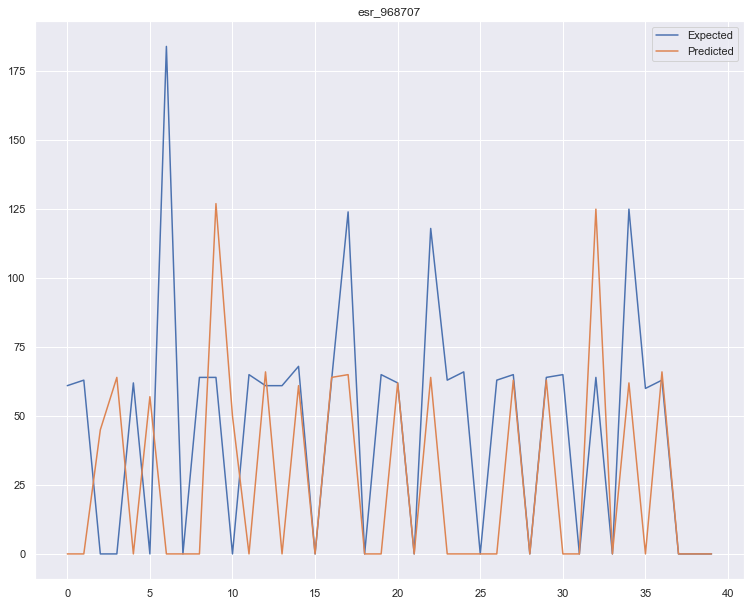

In [781]:
print('MAE: %.3f' % mean_absolute_error(y_test, predictions))
# plot expected vs preducted
plt.plot(y_test.values, label='Expected')
plt.plot(y_pred, label='Predicted')
plt.title('esr_968707')
plt.legend()
plt.show()

100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


MAE: 40.220


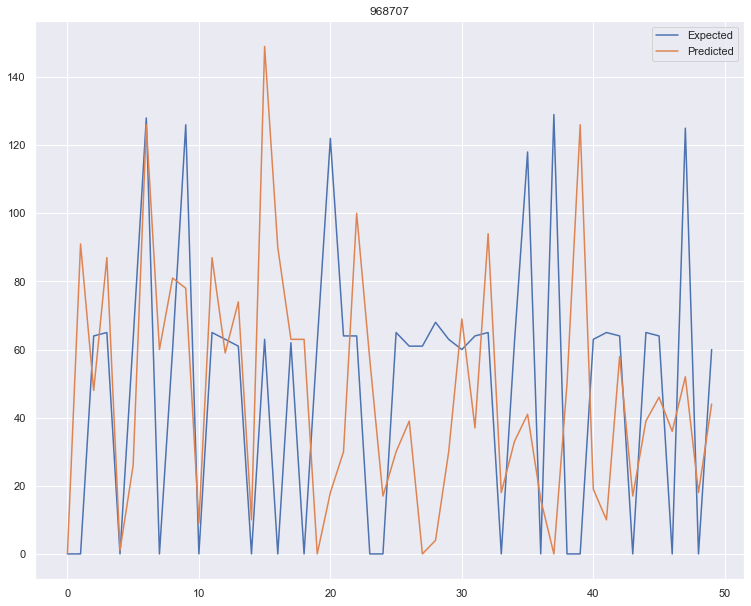

In [827]:
series = full_tdf_op[full_tdf_op.index == '968707'].loc['968707']
predict_and_plot(series,full_tdf_op,st_id)

#### AutoML H2O

In [830]:
import h2o
from h2o.estimators import H2OXGBoostEstimator

In [831]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment AdoptOpenJDK-11.0.11+9 (build 11.0.11+9); OpenJDK 64-Bit Server VM AdoptOpenJDK-11.0.11+9 (build 11.0.11+9, mixed mode)
  Starting server from /usr/local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/46/n__pt5q101z9fpty0tfxds4m0000gn/T/tmpe8orllnv
  JVM stdout: /var/folders/46/n__pt5q101z9fpty0tfxds4m0000gn/T/tmpe8orllnv/h2o_kost_started_from_python.out
  JVM stderr: /var/folders/46/n__pt5q101z9fpty0tfxds4m0000gn/T/tmpe8orllnv/h2o_kost_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_kost_bnu407
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [917]:
automl_model = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=42)

automl_model.train(x=list(esr_968707.columns),
                  y="target",
                  training_frame=h2o.H2OFrame(train),
                  validation_frame=h2o.H2OFrame(test))

perf = automl_model.model_performance(train=h2o.H2OFrame(train),valid=h2o.H2OFrame(test))


pred = automl_model.predict(h2o.H2OFrame(test))

feature_interactions = automl_model.feature_interaction()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [918]:
aml_predict = pred.as_data_frame().values
aml_predict = aml_predict.reshape(aml_predict.shape[0]).astype(int)
t =[]
for i in aml_predict:
    t.append(max(0,i))
aml_predict = np.array(t)

In [920]:
perf


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 5.819210140953674
RMSE: 2.412303907254157
MAE: 1.4570172125952585
RMSLE: NaN
Mean Residual Deviance: 5.819210140953674


MAE: 41.200


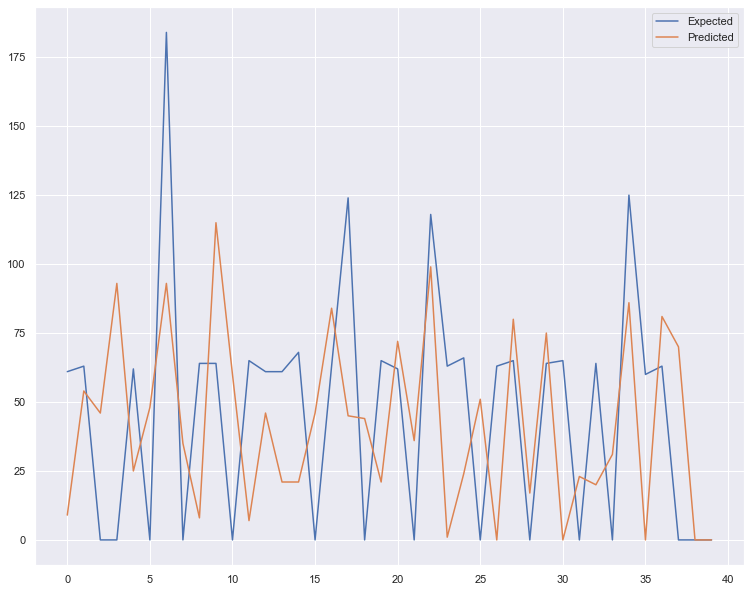

In [919]:
print('MAE: %.3f' % mean_absolute_error(y_test, aml_predict))
plt.plot(test.target.values, label = 'Expected')
plt.plot(aml_predict, label = 'Predicted')
plt.legend()
plt.show()

In [935]:
print(f'Expct\tPred\tDelta')  
delta = []
for tst,pdct in zip(test.target.values,aml_predict):  
    print(f'{int(tst)}\t{pdct}\t{pdct-int(tst)}')
    delta.append(pdct-int(tst))

Expct	Pred	Delta
61	9	-52
63	54	-9
0	46	46
0	93	93
62	25	-37
0	48	48
184	93	-91
0	35	35
64	8	-56
64	115	51
0	60	60
65	7	-58
61	46	-15
61	21	-40
68	21	-47
0	46	46
63	84	21
124	45	-79
0	44	44
65	21	-44
62	72	10
0	36	36
118	99	-19
63	1	-62
66	24	-42
0	51	51
63	0	-63
65	80	15
0	17	17
64	75	11
65	0	-65
0	23	23
64	20	-44
0	31	31
125	86	-39
60	0	-60
63	81	18
0	70	70
0	0	0
0	0	0


#### CatBoost

In [957]:
model_catboost = CatBoostRegressor(iterations=3000,
                                   learning_rate=0.01,
                                   depth=10,ver
                                  )

In [958]:
model_catboost.fit(X_train,y_train)

0:	learn: 44.5273318	total: 12.3ms	remaining: 36.9s
1:	learn: 44.4582933	total: 26ms	remaining: 38.9s
2:	learn: 44.4289177	total: 27.3ms	remaining: 27.3s
3:	learn: 44.3235664	total: 43.9ms	remaining: 32.9s
4:	learn: 44.2519997	total: 56.3ms	remaining: 33.8s
5:	learn: 44.1676781	total: 71.6ms	remaining: 35.7s
6:	learn: 44.0938217	total: 83.6ms	remaining: 35.7s
7:	learn: 44.0138759	total: 100ms	remaining: 37.4s
8:	learn: 43.9700094	total: 115ms	remaining: 38.2s
9:	learn: 43.9105208	total: 130ms	remaining: 39s
10:	learn: 43.8249131	total: 144ms	remaining: 39.2s
11:	learn: 43.7645268	total: 158ms	remaining: 39.4s
12:	learn: 43.6726249	total: 174ms	remaining: 40.1s
13:	learn: 43.6205402	total: 189ms	remaining: 40.2s
14:	learn: 43.5320132	total: 204ms	remaining: 40.6s
15:	learn: 43.4579643	total: 218ms	remaining: 40.7s
16:	learn: 43.3866094	total: 230ms	remaining: 40.4s
17:	learn: 43.3044973	total: 244ms	remaining: 40.3s
18:	learn: 43.2452811	total: 257ms	remaining: 40.3s
19:	learn: 43.19311

158:	learn: 36.0471577	total: 2.14s	remaining: 38.3s
159:	learn: 36.0094328	total: 2.16s	remaining: 38.3s
160:	learn: 35.9814073	total: 2.17s	remaining: 38.3s
161:	learn: 35.9405528	total: 2.18s	remaining: 38.3s
162:	learn: 35.9243265	total: 2.2s	remaining: 38.2s
163:	learn: 35.8882122	total: 2.21s	remaining: 38.2s
164:	learn: 35.8464440	total: 2.22s	remaining: 38.1s
165:	learn: 35.7978274	total: 2.23s	remaining: 38.1s
166:	learn: 35.7794706	total: 2.25s	remaining: 38.2s
167:	learn: 35.7757952	total: 2.26s	remaining: 38s
168:	learn: 35.7190110	total: 2.27s	remaining: 38s
169:	learn: 35.6608607	total: 2.29s	remaining: 38s
170:	learn: 35.6378539	total: 2.3s	remaining: 38s
171:	learn: 35.5796597	total: 2.31s	remaining: 38s
172:	learn: 35.5445419	total: 2.33s	remaining: 38s
173:	learn: 35.5092454	total: 2.34s	remaining: 38s
174:	learn: 35.4781998	total: 2.35s	remaining: 38s
175:	learn: 35.4543847	total: 2.37s	remaining: 38s
176:	learn: 35.4074585	total: 2.38s	remaining: 38s
177:	learn: 35.

315:	learn: 30.8133496	total: 4.26s	remaining: 36.2s
316:	learn: 30.7748658	total: 4.28s	remaining: 36.2s
317:	learn: 30.7640089	total: 4.28s	remaining: 36.1s
318:	learn: 30.7265720	total: 4.3s	remaining: 36.1s
319:	learn: 30.6737006	total: 4.31s	remaining: 36.1s
320:	learn: 30.6337218	total: 4.33s	remaining: 36.1s
321:	learn: 30.5976986	total: 4.34s	remaining: 36.1s
322:	learn: 30.5827339	total: 4.36s	remaining: 36.1s
323:	learn: 30.5672066	total: 4.36s	remaining: 36s
324:	learn: 30.5444011	total: 4.38s	remaining: 36s
325:	learn: 30.5160375	total: 4.39s	remaining: 36s
326:	learn: 30.4833446	total: 4.4s	remaining: 36s
327:	learn: 30.4456430	total: 4.42s	remaining: 36s
328:	learn: 30.4168156	total: 4.43s	remaining: 35.9s
329:	learn: 30.3764717	total: 4.44s	remaining: 36s
330:	learn: 30.3609798	total: 4.46s	remaining: 36s
331:	learn: 30.3428215	total: 4.47s	remaining: 36s
332:	learn: 30.3120634	total: 4.49s	remaining: 35.9s
333:	learn: 30.2801170	total: 4.5s	remaining: 35.9s
334:	learn: 

471:	learn: 26.8886057	total: 6.34s	remaining: 33.9s
472:	learn: 26.8508217	total: 6.35s	remaining: 33.9s
473:	learn: 26.8097000	total: 6.37s	remaining: 33.9s
474:	learn: 26.8003875	total: 6.38s	remaining: 33.9s
475:	learn: 26.7901044	total: 6.39s	remaining: 33.9s
476:	learn: 26.7745636	total: 6.41s	remaining: 33.9s
477:	learn: 26.7537637	total: 6.42s	remaining: 33.9s
478:	learn: 26.7203755	total: 6.44s	remaining: 33.9s
479:	learn: 26.6990471	total: 6.45s	remaining: 33.9s
480:	learn: 26.6599179	total: 6.47s	remaining: 33.9s
481:	learn: 26.6198422	total: 6.48s	remaining: 33.9s
482:	learn: 26.5865349	total: 6.5s	remaining: 33.9s
483:	learn: 26.5742957	total: 6.51s	remaining: 33.8s
484:	learn: 26.5604934	total: 6.52s	remaining: 33.8s
485:	learn: 26.5318018	total: 6.54s	remaining: 33.8s
486:	learn: 26.5076914	total: 6.55s	remaining: 33.8s
487:	learn: 26.4864820	total: 6.57s	remaining: 33.8s
488:	learn: 26.4500734	total: 6.58s	remaining: 33.8s
489:	learn: 26.4200544	total: 6.6s	remaining: 3

627:	learn: 23.0635017	total: 8.61s	remaining: 32.5s
628:	learn: 23.0446728	total: 8.62s	remaining: 32.5s
629:	learn: 23.0139019	total: 8.64s	remaining: 32.5s
630:	learn: 23.0063711	total: 8.64s	remaining: 32.4s
631:	learn: 22.9979932	total: 8.64s	remaining: 32.4s
632:	learn: 22.9829976	total: 8.65s	remaining: 32.4s
633:	learn: 22.9463088	total: 8.67s	remaining: 32.4s
634:	learn: 22.9120429	total: 8.68s	remaining: 32.3s
635:	learn: 22.8918346	total: 8.7s	remaining: 32.3s
636:	learn: 22.8880974	total: 8.71s	remaining: 32.3s
637:	learn: 22.8571910	total: 8.73s	remaining: 32.3s
638:	learn: 22.8276070	total: 8.74s	remaining: 32.3s
639:	learn: 22.7975016	total: 8.76s	remaining: 32.3s
640:	learn: 22.7960533	total: 8.76s	remaining: 32.3s
641:	learn: 22.7536346	total: 8.78s	remaining: 32.2s
642:	learn: 22.7333435	total: 8.79s	remaining: 32.2s
643:	learn: 22.7308774	total: 8.8s	remaining: 32.2s
644:	learn: 22.7262254	total: 8.81s	remaining: 32.2s
645:	learn: 22.7067757	total: 8.83s	remaining: 3

783:	learn: 19.6537025	total: 10.8s	remaining: 30.4s
784:	learn: 19.6246171	total: 10.8s	remaining: 30.4s
785:	learn: 19.6083407	total: 10.8s	remaining: 30.4s
786:	learn: 19.5719872	total: 10.8s	remaining: 30.4s
787:	learn: 19.5475361	total: 10.8s	remaining: 30.4s
788:	learn: 19.5435242	total: 10.8s	remaining: 30.4s
789:	learn: 19.5149513	total: 10.9s	remaining: 30.4s
790:	learn: 19.4930684	total: 10.9s	remaining: 30.4s
791:	learn: 19.4690544	total: 10.9s	remaining: 30.4s
792:	learn: 19.4384819	total: 10.9s	remaining: 30.3s
793:	learn: 19.4354172	total: 10.9s	remaining: 30.3s
794:	learn: 19.4111973	total: 10.9s	remaining: 30.3s
795:	learn: 19.3888978	total: 10.9s	remaining: 30.3s
796:	learn: 19.3781345	total: 10.9s	remaining: 30.2s
797:	learn: 19.3465313	total: 11s	remaining: 30.2s
798:	learn: 19.3267913	total: 11s	remaining: 30.2s
799:	learn: 19.3036980	total: 11s	remaining: 30.2s
800:	learn: 19.2874522	total: 11s	remaining: 30.2s
801:	learn: 19.2809978	total: 11s	remaining: 30.2s
802

940:	learn: 16.3312602	total: 13.1s	remaining: 28.6s
941:	learn: 16.3096314	total: 13.1s	remaining: 28.6s
942:	learn: 16.2953052	total: 13.1s	remaining: 28.6s
943:	learn: 16.2720934	total: 13.1s	remaining: 28.6s
944:	learn: 16.2535416	total: 13.1s	remaining: 28.5s
945:	learn: 16.2272983	total: 13.1s	remaining: 28.5s
946:	learn: 16.2095843	total: 13.2s	remaining: 28.5s
947:	learn: 16.1812448	total: 13.2s	remaining: 28.5s
948:	learn: 16.1732216	total: 13.2s	remaining: 28.5s
949:	learn: 16.1548832	total: 13.2s	remaining: 28.5s
950:	learn: 16.1388214	total: 13.2s	remaining: 28.5s
951:	learn: 16.1126761	total: 13.2s	remaining: 28.4s
952:	learn: 16.0885072	total: 13.2s	remaining: 28.4s
953:	learn: 16.0678650	total: 13.3s	remaining: 28.4s
954:	learn: 16.0434512	total: 13.3s	remaining: 28.4s
955:	learn: 16.0204630	total: 13.3s	remaining: 28.4s
956:	learn: 15.9976258	total: 13.3s	remaining: 28.4s
957:	learn: 15.9740842	total: 13.3s	remaining: 28.4s
958:	learn: 15.9560234	total: 13.3s	remaining:

1094:	learn: 13.6415454	total: 15.3s	remaining: 26.6s
1095:	learn: 13.6244372	total: 15.3s	remaining: 26.6s
1096:	learn: 13.6109062	total: 15.3s	remaining: 26.6s
1097:	learn: 13.5962007	total: 15.4s	remaining: 26.6s
1098:	learn: 13.5759608	total: 15.4s	remaining: 26.6s
1099:	learn: 13.5554521	total: 15.4s	remaining: 26.6s
1100:	learn: 13.5412908	total: 15.4s	remaining: 26.6s
1101:	learn: 13.5217356	total: 15.4s	remaining: 26.6s
1102:	learn: 13.5059612	total: 15.4s	remaining: 26.5s
1103:	learn: 13.4929360	total: 15.4s	remaining: 26.5s
1104:	learn: 13.4812274	total: 15.5s	remaining: 26.5s
1105:	learn: 13.4687023	total: 15.5s	remaining: 26.5s
1106:	learn: 13.4558864	total: 15.5s	remaining: 26.5s
1107:	learn: 13.4390961	total: 15.5s	remaining: 26.5s
1108:	learn: 13.4215277	total: 15.5s	remaining: 26.5s
1109:	learn: 13.4102529	total: 15.5s	remaining: 26.5s
1110:	learn: 13.3977430	total: 15.6s	remaining: 26.5s
1111:	learn: 13.3851767	total: 15.6s	remaining: 26.4s
1112:	learn: 13.3757628	tota

1247:	learn: 11.6500882	total: 17.5s	remaining: 24.6s
1248:	learn: 11.6428192	total: 17.5s	remaining: 24.6s
1249:	learn: 11.6282477	total: 17.6s	remaining: 24.6s
1250:	learn: 11.6121985	total: 17.6s	remaining: 24.6s
1251:	learn: 11.6065517	total: 17.6s	remaining: 24.6s
1252:	learn: 11.5957327	total: 17.6s	remaining: 24.5s
1253:	learn: 11.5821352	total: 17.6s	remaining: 24.5s
1254:	learn: 11.5744810	total: 17.6s	remaining: 24.5s
1255:	learn: 11.5608850	total: 17.6s	remaining: 24.5s
1256:	learn: 11.5520214	total: 17.7s	remaining: 24.5s
1257:	learn: 11.5342903	total: 17.7s	remaining: 24.5s
1258:	learn: 11.5181892	total: 17.7s	remaining: 24.5s
1259:	learn: 11.5079316	total: 17.7s	remaining: 24.5s
1260:	learn: 11.4972291	total: 17.7s	remaining: 24.4s
1261:	learn: 11.4855003	total: 17.7s	remaining: 24.4s
1262:	learn: 11.4690427	total: 17.8s	remaining: 24.4s
1263:	learn: 11.4621955	total: 17.8s	remaining: 24.4s
1264:	learn: 11.4543962	total: 17.8s	remaining: 24.4s
1265:	learn: 11.4480401	tota

1400:	learn: 10.1364143	total: 19.6s	remaining: 22.4s
1401:	learn: 10.1228733	total: 19.6s	remaining: 22.4s
1402:	learn: 10.1080771	total: 19.6s	remaining: 22.3s
1403:	learn: 10.1039395	total: 19.6s	remaining: 22.3s
1404:	learn: 10.0924404	total: 19.7s	remaining: 22.3s
1405:	learn: 10.0853647	total: 19.7s	remaining: 22.3s
1406:	learn: 10.0720401	total: 19.7s	remaining: 22.3s
1407:	learn: 10.0647313	total: 19.7s	remaining: 22.3s
1408:	learn: 10.0503215	total: 19.7s	remaining: 22.2s
1409:	learn: 10.0352088	total: 19.7s	remaining: 22.2s
1410:	learn: 10.0253140	total: 19.7s	remaining: 22.2s
1411:	learn: 10.0186111	total: 19.7s	remaining: 22.2s
1412:	learn: 10.0013783	total: 19.8s	remaining: 22.2s
1413:	learn: 9.9911952	total: 19.8s	remaining: 22.2s
1414:	learn: 9.9870626	total: 19.8s	remaining: 22.2s
1415:	learn: 9.9768122	total: 19.8s	remaining: 22.1s
1416:	learn: 9.9681119	total: 19.8s	remaining: 22.1s
1417:	learn: 9.9617999	total: 19.8s	remaining: 22.1s
1418:	learn: 9.9512356	total: 19.

1556:	learn: 8.7746013	total: 21.7s	remaining: 20.1s
1557:	learn: 8.7637380	total: 21.7s	remaining: 20.1s
1558:	learn: 8.7507267	total: 21.8s	remaining: 20.1s
1559:	learn: 8.7418563	total: 21.8s	remaining: 20.1s
1560:	learn: 8.7305388	total: 21.8s	remaining: 20.1s
1561:	learn: 8.7265824	total: 21.8s	remaining: 20.1s
1562:	learn: 8.7227115	total: 21.8s	remaining: 20.1s
1563:	learn: 8.7184975	total: 21.8s	remaining: 20s
1564:	learn: 8.7112019	total: 21.8s	remaining: 20s
1565:	learn: 8.7029023	total: 21.9s	remaining: 20s
1566:	learn: 8.7015404	total: 21.9s	remaining: 20s
1567:	learn: 8.6972715	total: 21.9s	remaining: 20s
1568:	learn: 8.6882149	total: 21.9s	remaining: 20s
1569:	learn: 8.6762093	total: 21.9s	remaining: 19.9s
1570:	learn: 8.6661247	total: 21.9s	remaining: 19.9s
1571:	learn: 8.6650767	total: 21.9s	remaining: 19.9s
1572:	learn: 8.6612216	total: 21.9s	remaining: 19.9s
1573:	learn: 8.6538044	total: 22s	remaining: 19.9s
1574:	learn: 8.6458110	total: 22s	remaining: 19.9s
1575:	lea

1712:	learn: 7.6437255	total: 23.9s	remaining: 18s
1713:	learn: 7.6344618	total: 23.9s	remaining: 18s
1714:	learn: 7.6289637	total: 24s	remaining: 17.9s
1715:	learn: 7.6259879	total: 24s	remaining: 17.9s
1716:	learn: 7.6170426	total: 24s	remaining: 17.9s
1717:	learn: 7.6138887	total: 24s	remaining: 17.9s
1718:	learn: 7.6067308	total: 24s	remaining: 17.9s
1719:	learn: 7.6015924	total: 24s	remaining: 17.9s
1720:	learn: 7.5935522	total: 24s	remaining: 17.9s
1721:	learn: 7.5861048	total: 24.1s	remaining: 17.9s
1722:	learn: 7.5792748	total: 24.1s	remaining: 17.8s
1723:	learn: 7.5758472	total: 24.1s	remaining: 17.8s
1724:	learn: 7.5712200	total: 24.1s	remaining: 17.8s
1725:	learn: 7.5632465	total: 24.1s	remaining: 17.8s
1726:	learn: 7.5585285	total: 24.1s	remaining: 17.8s
1727:	learn: 7.5530225	total: 24.1s	remaining: 17.8s
1728:	learn: 7.5450939	total: 24.2s	remaining: 17.8s
1729:	learn: 7.5351959	total: 24.2s	remaining: 17.7s
1730:	learn: 7.5260618	total: 24.2s	remaining: 17.7s
1731:	learn

1868:	learn: 6.6860801	total: 26.1s	remaining: 15.8s
1869:	learn: 6.6764606	total: 26.1s	remaining: 15.8s
1870:	learn: 6.6696880	total: 26.1s	remaining: 15.8s
1871:	learn: 6.6632334	total: 26.1s	remaining: 15.7s
1872:	learn: 6.6584039	total: 26.1s	remaining: 15.7s
1873:	learn: 6.6492827	total: 26.2s	remaining: 15.7s
1874:	learn: 6.6460883	total: 26.2s	remaining: 15.7s
1875:	learn: 6.6414357	total: 26.2s	remaining: 15.7s
1876:	learn: 6.6404727	total: 26.2s	remaining: 15.7s
1877:	learn: 6.6377638	total: 26.2s	remaining: 15.7s
1878:	learn: 6.6308448	total: 26.2s	remaining: 15.6s
1879:	learn: 6.6260722	total: 26.2s	remaining: 15.6s
1880:	learn: 6.6215786	total: 26.3s	remaining: 15.6s
1881:	learn: 6.6120361	total: 26.3s	remaining: 15.6s
1882:	learn: 6.6080956	total: 26.3s	remaining: 15.6s
1883:	learn: 6.6040388	total: 26.3s	remaining: 15.6s
1884:	learn: 6.5992475	total: 26.3s	remaining: 15.6s
1885:	learn: 6.5899061	total: 26.3s	remaining: 15.6s
1886:	learn: 6.5820142	total: 26.3s	remaining:

2024:	learn: 5.8599843	total: 28.3s	remaining: 13.6s
2025:	learn: 5.8572367	total: 28.3s	remaining: 13.6s
2026:	learn: 5.8522454	total: 28.3s	remaining: 13.6s
2027:	learn: 5.8461997	total: 28.4s	remaining: 13.6s
2028:	learn: 5.8434713	total: 28.4s	remaining: 13.6s
2029:	learn: 5.8386768	total: 28.4s	remaining: 13.6s
2030:	learn: 5.8323922	total: 28.4s	remaining: 13.5s
2031:	learn: 5.8272913	total: 28.4s	remaining: 13.5s
2032:	learn: 5.8239585	total: 28.4s	remaining: 13.5s
2033:	learn: 5.8172547	total: 28.4s	remaining: 13.5s
2034:	learn: 5.8142594	total: 28.5s	remaining: 13.5s
2035:	learn: 5.8060807	total: 28.5s	remaining: 13.5s
2036:	learn: 5.8000826	total: 28.5s	remaining: 13.5s
2037:	learn: 5.7929617	total: 28.5s	remaining: 13.5s
2038:	learn: 5.7877558	total: 28.5s	remaining: 13.4s
2039:	learn: 5.7797096	total: 28.5s	remaining: 13.4s
2040:	learn: 5.7764166	total: 28.5s	remaining: 13.4s
2041:	learn: 5.7732121	total: 28.6s	remaining: 13.4s
2042:	learn: 5.7640609	total: 28.6s	remaining:

2180:	learn: 5.1323792	total: 30.5s	remaining: 11.5s
2181:	learn: 5.1265422	total: 30.5s	remaining: 11.4s
2182:	learn: 5.1232141	total: 30.5s	remaining: 11.4s
2183:	learn: 5.1205122	total: 30.6s	remaining: 11.4s
2184:	learn: 5.1161332	total: 30.6s	remaining: 11.4s
2185:	learn: 5.1122053	total: 30.6s	remaining: 11.4s
2186:	learn: 5.1049231	total: 30.6s	remaining: 11.4s
2187:	learn: 5.1025818	total: 30.6s	remaining: 11.4s
2188:	learn: 5.0954208	total: 30.6s	remaining: 11.3s
2189:	learn: 5.0927301	total: 30.6s	remaining: 11.3s
2190:	learn: 5.0873151	total: 30.7s	remaining: 11.3s
2191:	learn: 5.0842422	total: 30.7s	remaining: 11.3s
2192:	learn: 5.0830553	total: 30.7s	remaining: 11.3s
2193:	learn: 5.0766793	total: 30.7s	remaining: 11.3s
2194:	learn: 5.0718207	total: 30.7s	remaining: 11.3s
2195:	learn: 5.0699205	total: 30.7s	remaining: 11.2s
2196:	learn: 5.0633481	total: 30.7s	remaining: 11.2s
2197:	learn: 5.0586316	total: 30.8s	remaining: 11.2s
2198:	learn: 5.0567031	total: 30.8s	remaining:

2336:	learn: 4.4972080	total: 32.8s	remaining: 9.3s
2337:	learn: 4.4911000	total: 32.8s	remaining: 9.28s
2338:	learn: 4.4832371	total: 32.8s	remaining: 9.27s
2339:	learn: 4.4783071	total: 32.8s	remaining: 9.26s
2340:	learn: 4.4747986	total: 32.8s	remaining: 9.24s
2341:	learn: 4.4731863	total: 32.8s	remaining: 9.23s
2342:	learn: 4.4704320	total: 32.9s	remaining: 9.21s
2343:	learn: 4.4649299	total: 32.9s	remaining: 9.2s
2344:	learn: 4.4608359	total: 32.9s	remaining: 9.19s
2345:	learn: 4.4580292	total: 32.9s	remaining: 9.17s
2346:	learn: 4.4505504	total: 32.9s	remaining: 9.16s
2347:	learn: 4.4431155	total: 32.9s	remaining: 9.14s
2348:	learn: 4.4372198	total: 32.9s	remaining: 9.13s
2349:	learn: 4.4367539	total: 33s	remaining: 9.12s
2350:	learn: 4.4306061	total: 33s	remaining: 9.1s
2351:	learn: 4.4276646	total: 33s	remaining: 9.09s
2352:	learn: 4.4207546	total: 33s	remaining: 9.08s
2353:	learn: 4.4162031	total: 33s	remaining: 9.06s
2354:	learn: 4.4128401	total: 33s	remaining: 9.05s
2355:	le

2492:	learn: 3.9622180	total: 35s	remaining: 7.12s
2493:	learn: 3.9619550	total: 35s	remaining: 7.1s
2494:	learn: 3.9595566	total: 35s	remaining: 7.09s
2495:	learn: 3.9555715	total: 35s	remaining: 7.08s
2496:	learn: 3.9551725	total: 35.1s	remaining: 7.06s
2497:	learn: 3.9529753	total: 35.1s	remaining: 7.05s
2498:	learn: 3.9527659	total: 35.1s	remaining: 7.04s
2499:	learn: 3.9503611	total: 35.1s	remaining: 7.02s
2500:	learn: 3.9477064	total: 35.1s	remaining: 7.01s
2501:	learn: 3.9434034	total: 35.1s	remaining: 6.99s
2502:	learn: 3.9381818	total: 35.1s	remaining: 6.98s
2503:	learn: 3.9351079	total: 35.2s	remaining: 6.96s
2504:	learn: 3.9339396	total: 35.2s	remaining: 6.95s
2505:	learn: 3.9293507	total: 35.2s	remaining: 6.94s
2506:	learn: 3.9280550	total: 35.2s	remaining: 6.92s
2507:	learn: 3.9249998	total: 35.2s	remaining: 6.91s
2508:	learn: 3.9246011	total: 35.2s	remaining: 6.89s
2509:	learn: 3.9204707	total: 35.2s	remaining: 6.88s
2510:	learn: 3.9180694	total: 35.3s	remaining: 6.87s
25

2648:	learn: 3.5043111	total: 37.3s	remaining: 4.94s
2649:	learn: 3.5021822	total: 37.3s	remaining: 4.92s
2650:	learn: 3.5018176	total: 37.3s	remaining: 4.91s
2651:	learn: 3.5001841	total: 37.3s	remaining: 4.9s
2652:	learn: 3.4981542	total: 37.3s	remaining: 4.88s
2653:	learn: 3.4934121	total: 37.3s	remaining: 4.87s
2654:	learn: 3.4931315	total: 37.4s	remaining: 4.85s
2655:	learn: 3.4877475	total: 37.4s	remaining: 4.84s
2656:	learn: 3.4875480	total: 37.4s	remaining: 4.83s
2657:	learn: 3.4840768	total: 37.4s	remaining: 4.81s
2658:	learn: 3.4838843	total: 37.4s	remaining: 4.8s
2659:	learn: 3.4800167	total: 37.4s	remaining: 4.78s
2660:	learn: 3.4798612	total: 37.4s	remaining: 4.77s
2661:	learn: 3.4758540	total: 37.5s	remaining: 4.76s
2662:	learn: 3.4742918	total: 37.5s	remaining: 4.74s
2663:	learn: 3.4741540	total: 37.5s	remaining: 4.73s
2664:	learn: 3.4705856	total: 37.5s	remaining: 4.71s
2665:	learn: 3.4670532	total: 37.5s	remaining: 4.7s
2666:	learn: 3.4667613	total: 37.5s	remaining: 4.

2804:	learn: 3.0836550	total: 39.6s	remaining: 2.75s
2805:	learn: 3.0816439	total: 39.6s	remaining: 2.74s
2806:	learn: 3.0796749	total: 39.6s	remaining: 2.72s
2807:	learn: 3.0775255	total: 39.6s	remaining: 2.71s
2808:	learn: 3.0760678	total: 39.6s	remaining: 2.69s
2809:	learn: 3.0749236	total: 39.6s	remaining: 2.68s
2810:	learn: 3.0727685	total: 39.6s	remaining: 2.67s
2811:	learn: 3.0722819	total: 39.7s	remaining: 2.65s
2812:	learn: 3.0701782	total: 39.7s	remaining: 2.64s
2813:	learn: 3.0678035	total: 39.7s	remaining: 2.62s
2814:	learn: 3.0654496	total: 39.7s	remaining: 2.61s
2815:	learn: 3.0618360	total: 39.7s	remaining: 2.6s
2816:	learn: 3.0572294	total: 39.7s	remaining: 2.58s
2817:	learn: 3.0562795	total: 39.8s	remaining: 2.57s
2818:	learn: 3.0535631	total: 39.8s	remaining: 2.55s
2819:	learn: 3.0529586	total: 39.8s	remaining: 2.54s
2820:	learn: 3.0498998	total: 39.8s	remaining: 2.52s
2821:	learn: 3.0476831	total: 39.8s	remaining: 2.51s
2822:	learn: 3.0474685	total: 39.8s	remaining: 

2960:	learn: 2.7076851	total: 41.8s	remaining: 550ms
2961:	learn: 2.7032195	total: 41.8s	remaining: 536ms
2962:	learn: 2.6999053	total: 41.8s	remaining: 522ms
2963:	learn: 2.6998138	total: 41.8s	remaining: 508ms
2964:	learn: 2.6997144	total: 41.8s	remaining: 494ms
2965:	learn: 2.6969201	total: 41.8s	remaining: 480ms
2966:	learn: 2.6961910	total: 41.9s	remaining: 466ms
2967:	learn: 2.6943495	total: 41.9s	remaining: 451ms
2968:	learn: 2.6926677	total: 41.9s	remaining: 437ms
2969:	learn: 2.6889879	total: 41.9s	remaining: 423ms
2970:	learn: 2.6855227	total: 41.9s	remaining: 409ms
2971:	learn: 2.6820786	total: 41.9s	remaining: 395ms
2972:	learn: 2.6818757	total: 42s	remaining: 381ms
2973:	learn: 2.6787877	total: 42s	remaining: 367ms
2974:	learn: 2.6766929	total: 42s	remaining: 353ms
2975:	learn: 2.6731628	total: 42s	remaining: 339ms
2976:	learn: 2.6705686	total: 42s	remaining: 325ms
2977:	learn: 2.6704937	total: 42s	remaining: 310ms
2978:	learn: 2.6678792	total: 42s	remaining: 296ms
2979:	l

In [959]:
catb_pred = model_catboost.predict(X_test)

MAE: 35.775


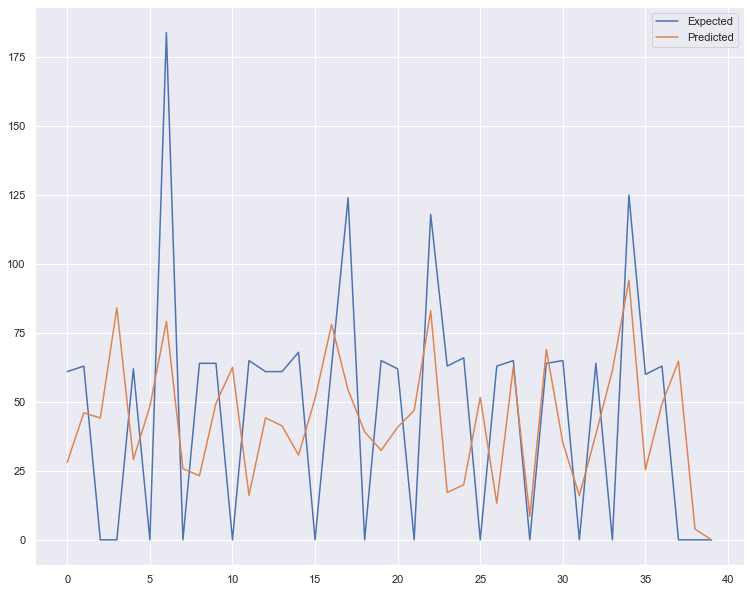

In [960]:
print('MAE: %.3f' % mean_absolute_error(y_test, catb_pred))
plt.plot(test.target.values, label = 'Expected')
plt.plot(catb_pred, label = 'Predicted')
plt.legend()
plt.show()